**PBS ADSORPTION STUDIES**

Rodrigo Toledo de Araujo \\
 Department of Electrical Engineering and Computation \\
 University of Campina Grande \\
 Campina Grande, Paraíba, Brazil

 rodrigo.araujo@ee.ufcg.edu.br

# 0. Molecular Analysis and Dilution

Molarity ($M$) is defined as the number of moles of solute ($n$) per liter of solution ($V$).

\begin{equation}
M = \frac{n}{V}
\end{equation}

The relationship between moles ($n$), mass ($m$), and molar mass ($M_m$), is shown in \autoref{eq:moles}.

\begin{equation}
n = \frac{m}{M_m}
\end{equation}

\autoref{eq: mass} is typically used to find the required mass ($m$) for the proposed molarity (Combining \autoref{eq:molarity} and \autoref{eq:moles}).

\begin{equation}
m = M \times V \times M_m
\end{equation}

As in the NaOH experiment, the different concentrations of NaOH were produced by making a dilution of one bigger concentration (See \autoref{eq:dilution} for more details).

\begin{equation}
    C_{\text{new}}V_{\text{new}} = C_{\text{initial}}V_{\text{initial}}
\end{equation}

The typical formulation for 1 L of PBS-1x includes:

* 137 mM NaCl, 2.7 mM KCl, 10 mM Na$_2$HPO$_4$, 1.8 mM KH$_2$PO$_4$


1. Sodium Chloride (NaCl)
\begin{equation}
\text{Mass required} = 0.137 \, \text{mol/L} \times 58.44 \, \text{g/mol} = 7.998 \, \text{g}
\end{equation}

2. Potassium Chloride (KCl)
\begin{equation}
\text{Mass required} = 0.0027 \, \text{mol/L} \times 74.55 \, \text{g/mol} = 0.201 \, \text{g}
\end{equation}

3. Disodium Phosphate (Na$_2$HPO$_4$)
\begin{equation}
\text{Mass required} = 0.01 \, \text{mol/L} \times 141.96 \, \text{g/mol} = 1.42 \, \text{g}
\end{equation}

4. Monopotassium Phosphate (KH$_2$PO$_4$)
\begin{equation}
\text{Mass required} = 0.0018 \, \text{mol/L} \times 136.09 \, \text{g/mol} = 0.245 \, \text{g}
\end{equation}

By following a similar procedure, the molarity and mass for PBS-5x and PBS-10x it is presented in Table.

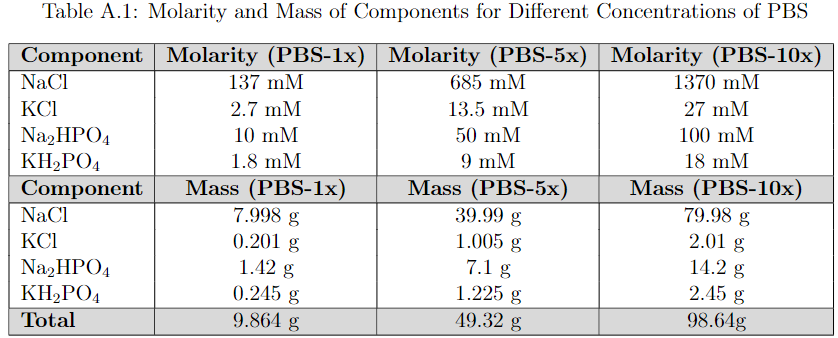

# 1. Importing Libraries

In [12]:
# Importing Libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
from cycler import cycler
import re
import jax
import jax.numpy as jnp
from typing import Callable, List
import subprocess
import os
import psutil
import tracemalloc
import subprocess

In [13]:
# Testing the backend
# Comando para obter informações sobre a GPU usando nvidia-smi
command = "nvidia-smi --query-gpu=name,memory.total --format=csv,noheader,nounits"
# Execute o comando e capture a saída
output = subprocess.check_output(command, shell=True, encoding="utf-8")
# Separe as linhas da saída
lines = output.strip().split("\n")
# imprima as informações da saída
for idx, line in enumerate(lines):
    name, memory = line.strip().split(",")
    print(f"GPU {idx} - Nome: {name}, Memória Total: {memory} MB")
    print(f"Jax backend:{jax.default_backend()}")
jax.devices()

GPU 0 - Nome: NVIDIA GeForce RTX 4060 Laptop GPU, Memória Total:  8188 MB
Jax backend:cpu


[CpuDevice(id=0)]

In [14]:
# Use LaTeX for text rendering
# Define a more scientific color cycle
scientific_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.rcParams.update({
    "text.usetex": True,
    "axes.labelsize": 12,
    "font.size": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    'axes.prop_cycle':cycler(color=scientific_colors)
})

# write me a python code to plot a sine function


# 2. Fitting the PBS data into the Langmuir Model

## 2.1 Theory

In 1932, Langmuir developed the Langmuir adsorption isotherm, which describes the adsorption and desorption of molecules on a surface \cite{langmuir1932vapor}.

Following the principles of physical chemistry for reaction kinetics and thermodynamics the change in the amount of solute adsorbed on a surface per unit area over time can be expressed in the following equation \cite{latour2015langmuir}.



$$\frac{dq}{dt} = k_aC(Q-q)-k_dq$$


where $C$ is the solution concentration, $Q$ is the amount of solute adsorbed when all of the biding sites are filled, $q$ is the amount of solute adsorbed on the surface given a solution concentration $C$, $t$ is the time and $(Q-q)$ is the number of vacant sites for adsorption.

Under dynamic equilibrium conditions, $dq/dt=0$, the equilibrium constant and $q$ are given by:

$$K_A=\frac{k_a}{k_d} = \frac{q}{C(Q-q)}$$

$$q =\frac{QC}{C+K_A^{-1}}$$

The following equation is used  to quantify adsorption coverage (i.e. normalized coverage $0<\Theta<1$).

$$\Theta = \frac{\text{Occupied region}}{\text{Total available region}} = \frac{q}{Q}=\frac{V_a}{V_m} = \frac{m_a}{m_m}$$

where $\Theta $ represents the coverage of the surface, $ V_a $ is the volume of the adsorbate adhered, $ V_m $ is the maximum volume of adsorbate in a monolayer, $ m_a $ is the number of moles adhered, and $ m_m $ is the maximum number of moles of adsorbate in a monolayer.

Then, the first order differential equation (i.e. Langmuir isotherm) in terms of the normalized coverage is:

$$\frac{d(q/Q)}{dt}=\frac{d\Theta}{dt} = k_aC(1-\Theta)-k_d\Theta$$

And has exponential solutions (i.e. $\Theta(t)$) given by:

   $$ \Theta(t) = \left(\frac{k_aC}{k_aC+k_d}\right)\left(1-e^{-({k_aC+k_d})t}\right), \quad \text{or}\quad
\Theta(t) = \left(\frac{C}{C+K_A^{-1}}\right)\left(1-e^{-({k_aC+k_d})t}\right)$$

The molecular surface under steady state conditions, from the previous equation is given by:

$$\Theta^\infty=\lim_{t\rightarrow\infty}\Theta(t)=\frac{C}{C+K_A^{-1}}$$




## 2.2 Finding Initial Values

### A. Theory

The effective refractive index variation $\Delta \mathcal{N}_s^{\text{eff}}$ can be estimated by using the surface coverage (i.e., $\Theta_{\text{mol}}(C_s)$, derived from one of the adsorption models) as shown in the following equation:

$$\Delta \mathcal{N}_s^{\text{eff}}(C_s) = \Delta \mathcal{N}_{\text{mol}}^{\text{max}}\Theta_{\text{mol}}(C_s)$$

Being:

$$\Theta_{\text{mol}}(C)=\frac{C}{C+K_A^{-1}}\theta_\infty$$

Then:

$$\Delta \mathcal{N}_s^{\text{eff}} = \Delta \mathcal{N}_{\text{mol}}^{\text{max}}\frac{C}{C+K_A^{-1}}\theta_{\infty} \longrightarrow\Delta \mathcal{N}_s^{\text{eff}}K_A^{-1}-\Delta \mathcal{N}_{\text{mol}}^{\text{max}}\theta_{\infty} C=-C\Delta \mathcal{N}_s^{\text{eff}}$$

Using the information of two points: ($C_1$, $\Delta \mathcal{N}_{s1}^{\text{eff}}$) and ($C_2$, $\Delta \mathcal{N}_{s2}^{\text{eff}}$), a linear set of equations can be derived (In the matrix form):

$$
  \begin{bmatrix}
\Delta \mathcal{N}_{s1}^{\text{eff}} & -C_1\\
\Delta \mathcal{N}_{s2}^{\text{eff}} & -C_2
\end{bmatrix}\begin{bmatrix}
K_A^{-1}\\
\Delta \mathcal{N}_{\text{mol}}^{\text{max}}\theta_{\infty}
\end{bmatrix}=\begin{bmatrix}
-C_1\Delta \mathcal{N}_{s1}^{\text{eff}}\\
-C_2\Delta \mathcal{N}_{s2}^{\text{eff}}
\end{bmatrix}  
$$

Where:

* $\Delta \mathcal{N}_{\text{mol}}^{\text{max}}$, $\theta_{\infty}$  and $K_A^{-1}$ are the constant unknowns
* $C$ and $\Delta \mathcal{N}_s^{\text{eff}}$ are the coefficients (we already know their values) that vary.

Given that the values of the two points [($C_1$, $\Delta \mathcal{N}_{s1}^{\text{eff}}$) and ($C_2$, $\Delta \mathcal{N}_{s2}^{\text{eff}}$)] are known, by using a numerical method (e.g., Gauss method), the unknown variables are quickly defined.

### B. Importing data and visualization

In [15]:
# Step 2: Define the directory containing the Excel files
dir_path = r"Data/Curvas_PBS - Copy"
#dir_path = 'G:\My Drive\Colab Notebooks\Biosensors\Data\Curvas_PBS - Copy'
# Step 3: Initialize an empty dictionary to store data'
data_dict = {}

# Step 4: List all files in the directory
file_list = os.listdir(dir_path)

# Step 5: Sort files numerically based on the number in the file name
def extract_number(file_name):
    match = re.search(r'\d+', file_name)
    return int(match.group()) if match else float('inf')

file_list = sorted(file_list, key=extract_number)

# Step 6: Loop through the sorted files and read each Excel file into the dictionary
for file_name in file_list:
    if file_name.endswith('.csv'):
        file_path = os.path.join(dir_path, file_name)
        data_dict[file_name] = pd.read_csv(file_path,delimiter=';')

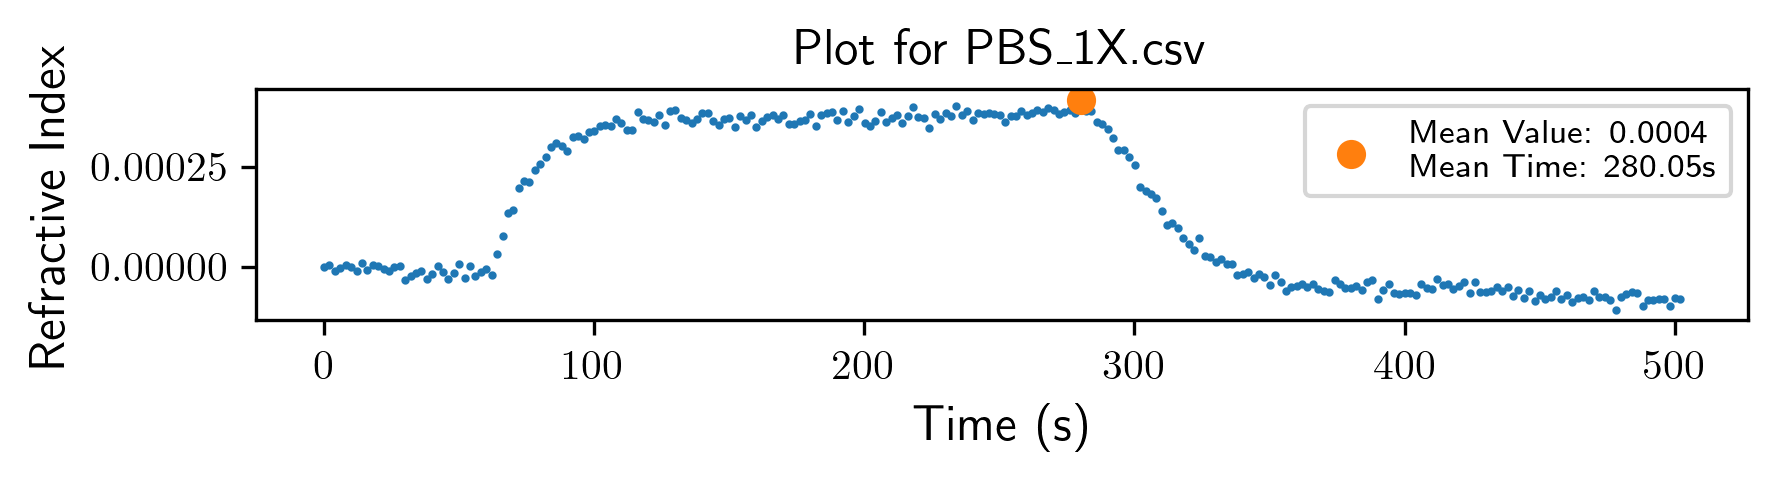

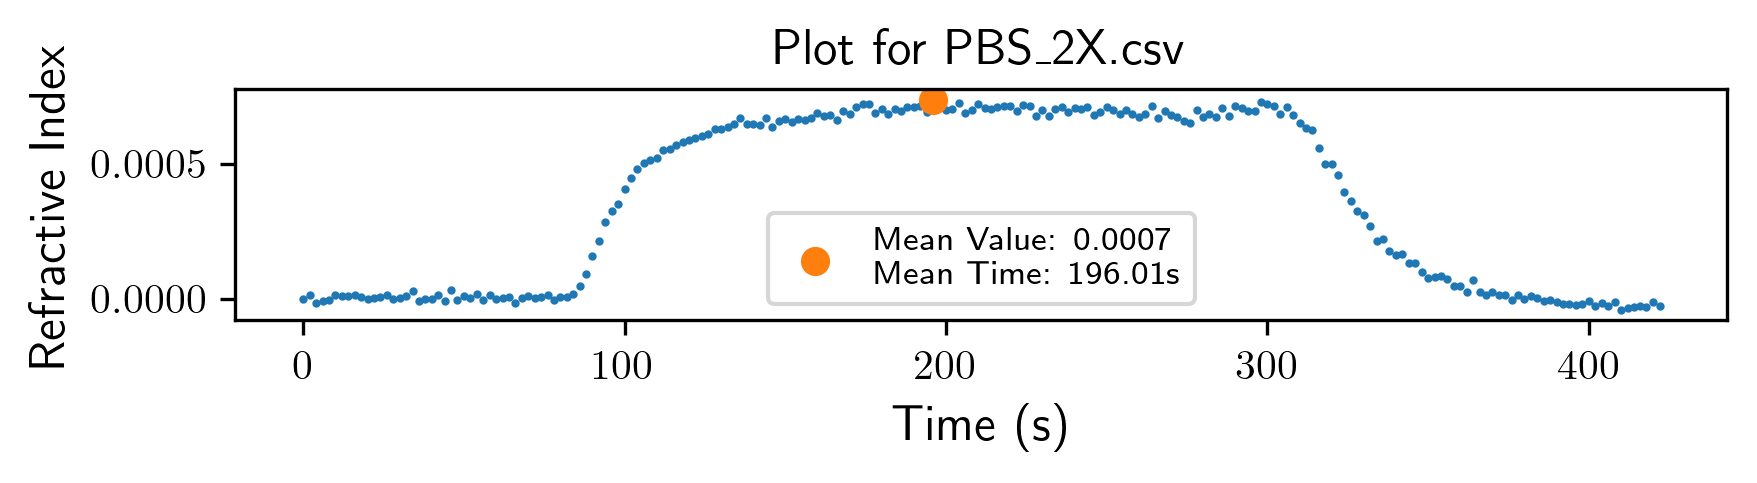

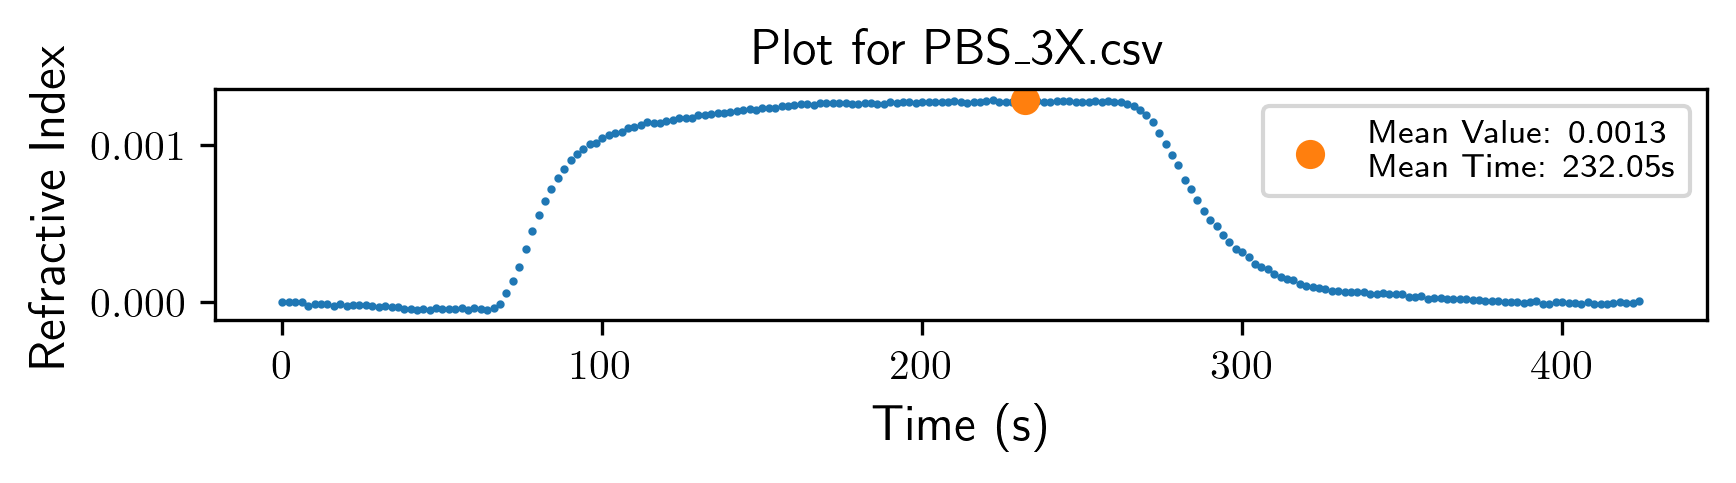

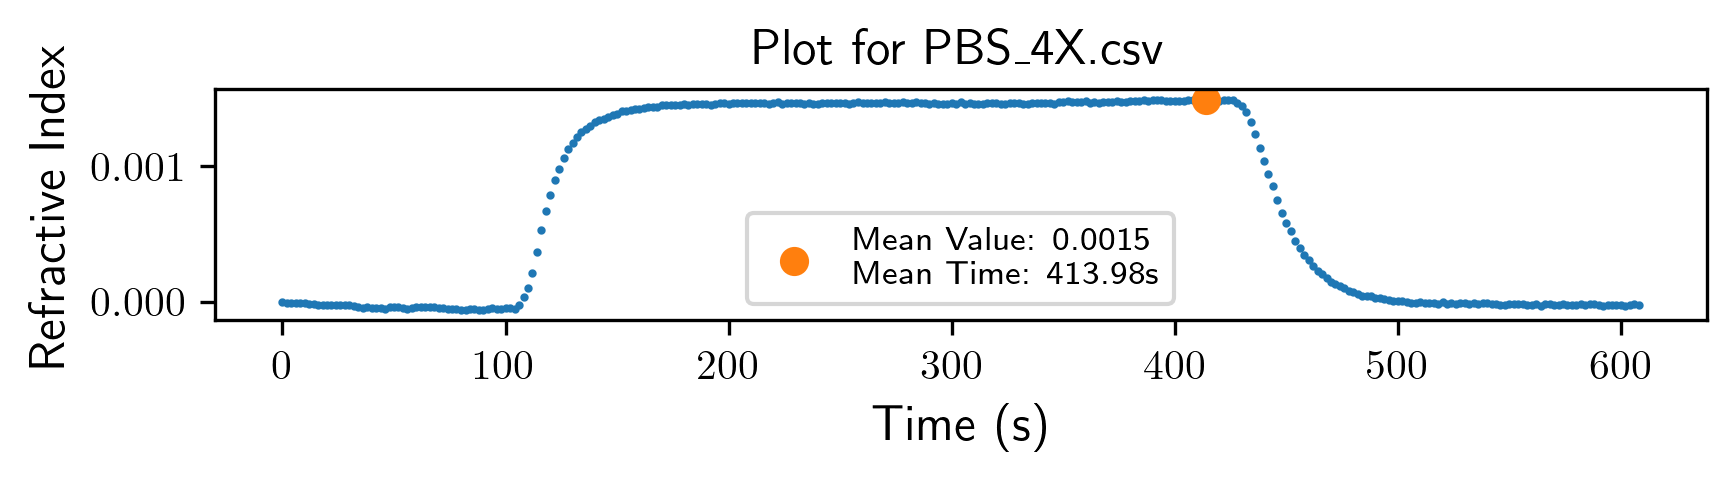

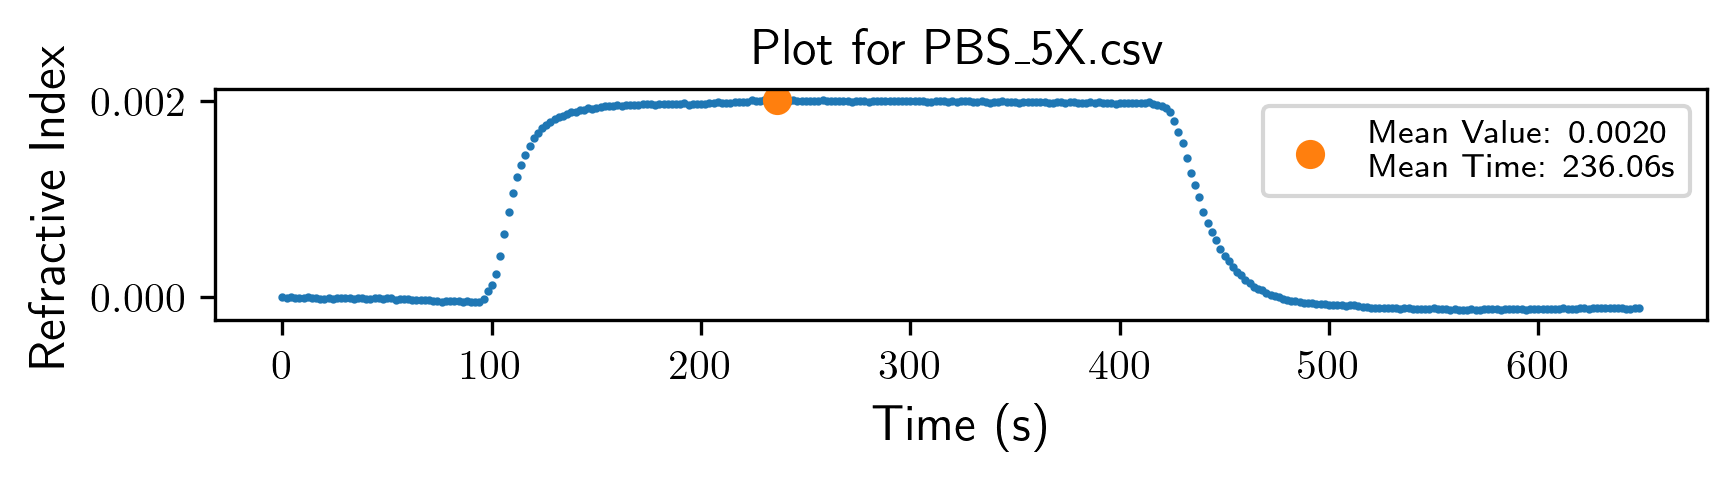

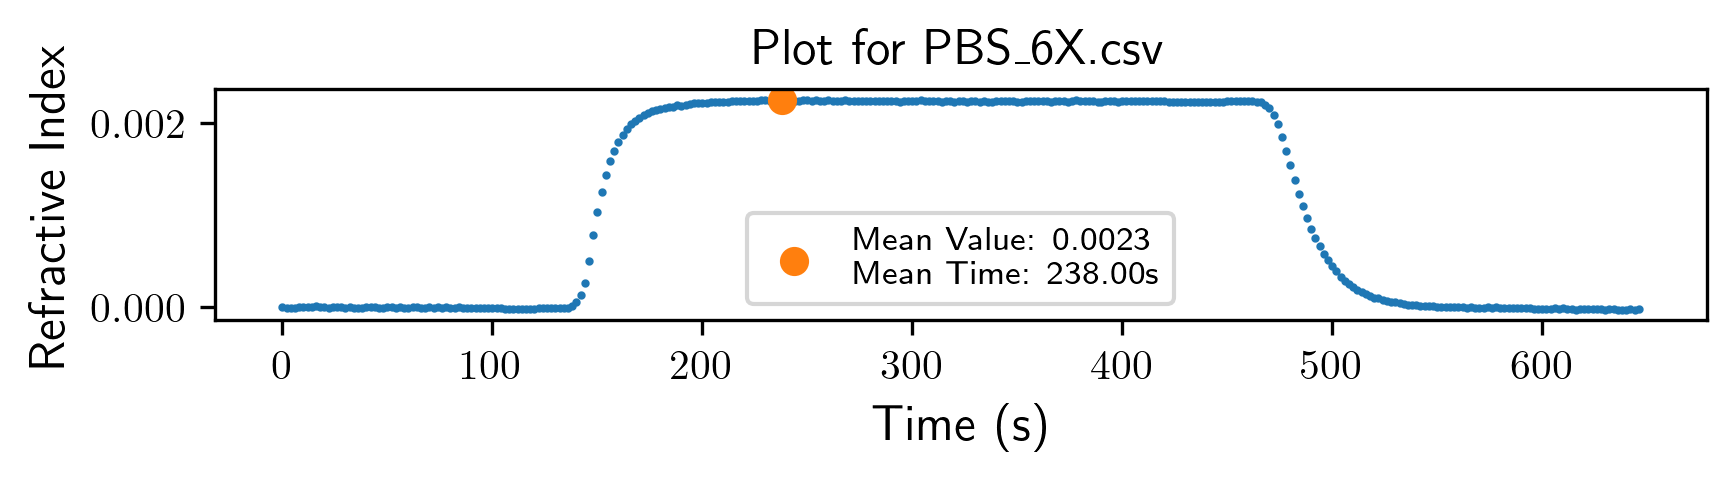

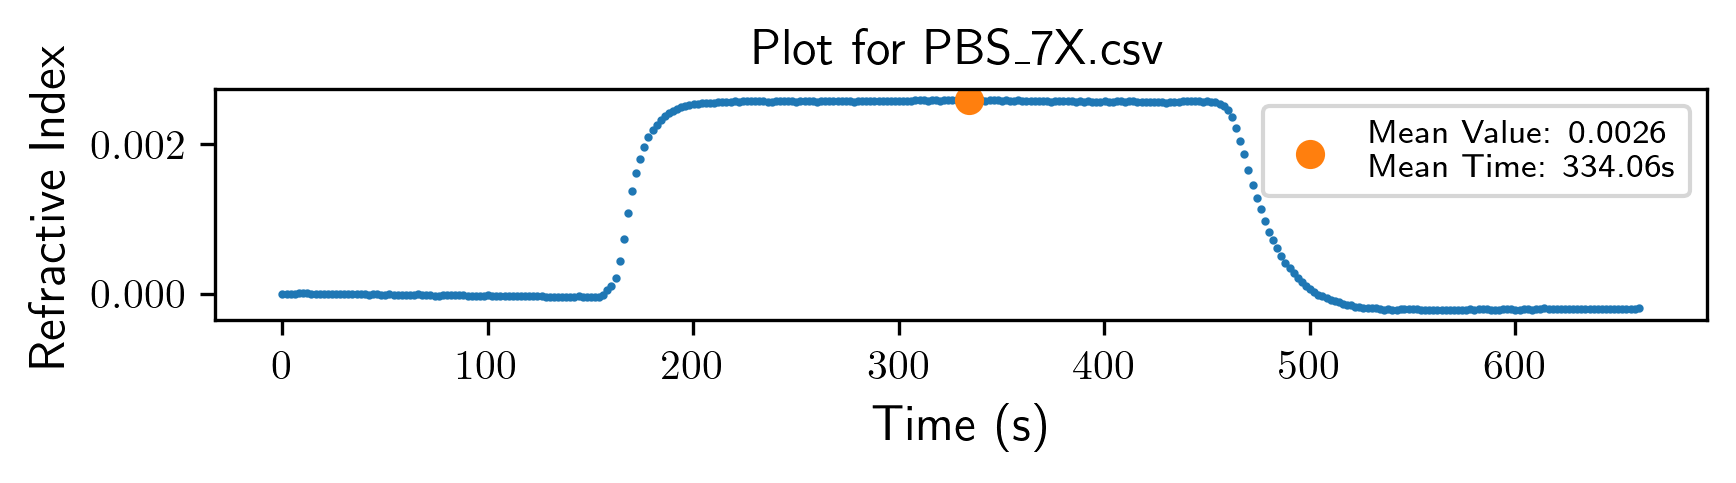

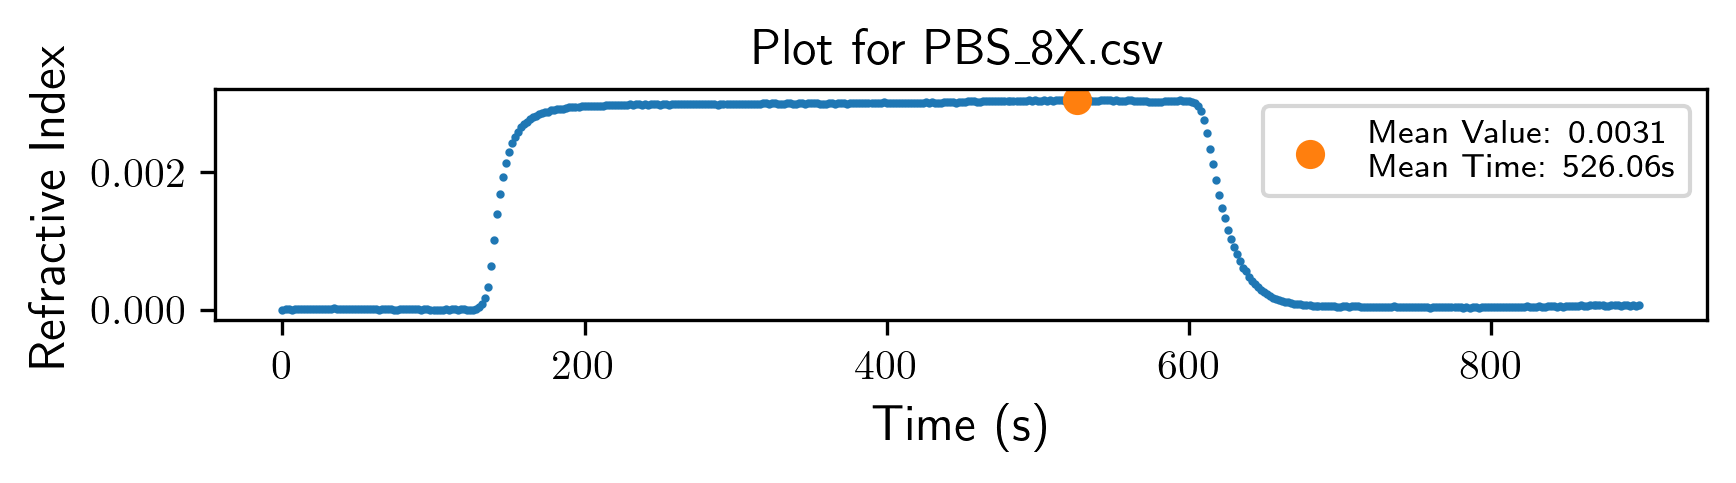

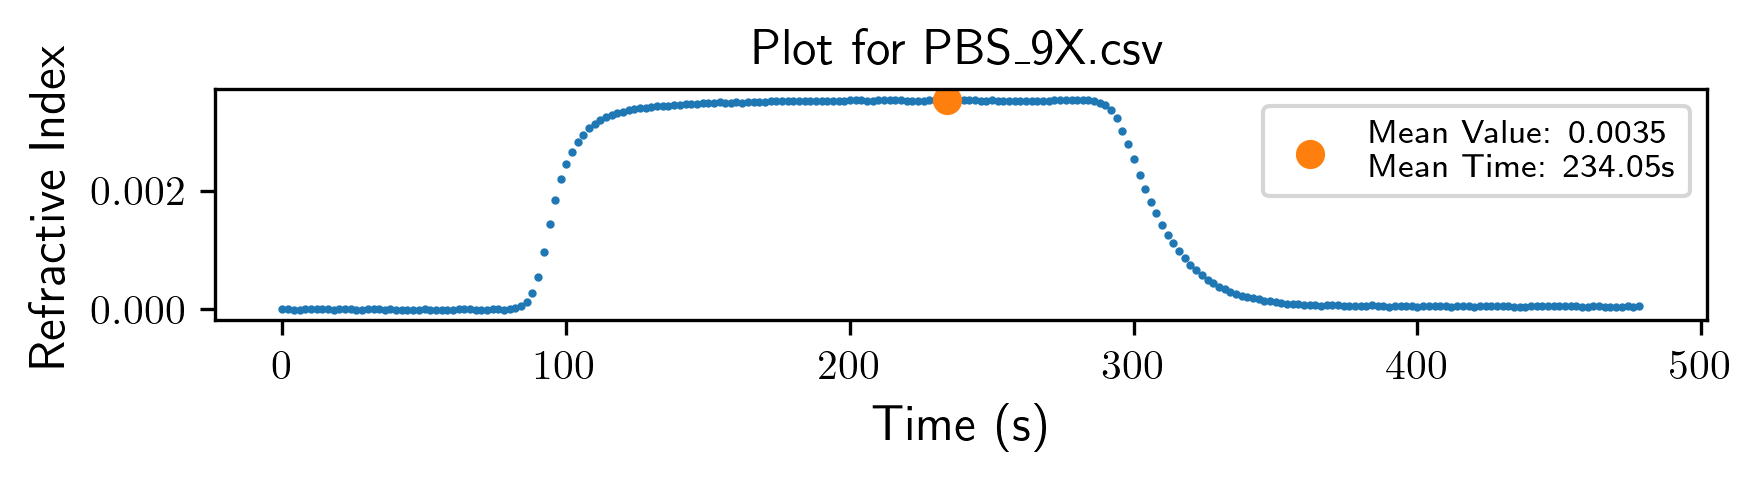

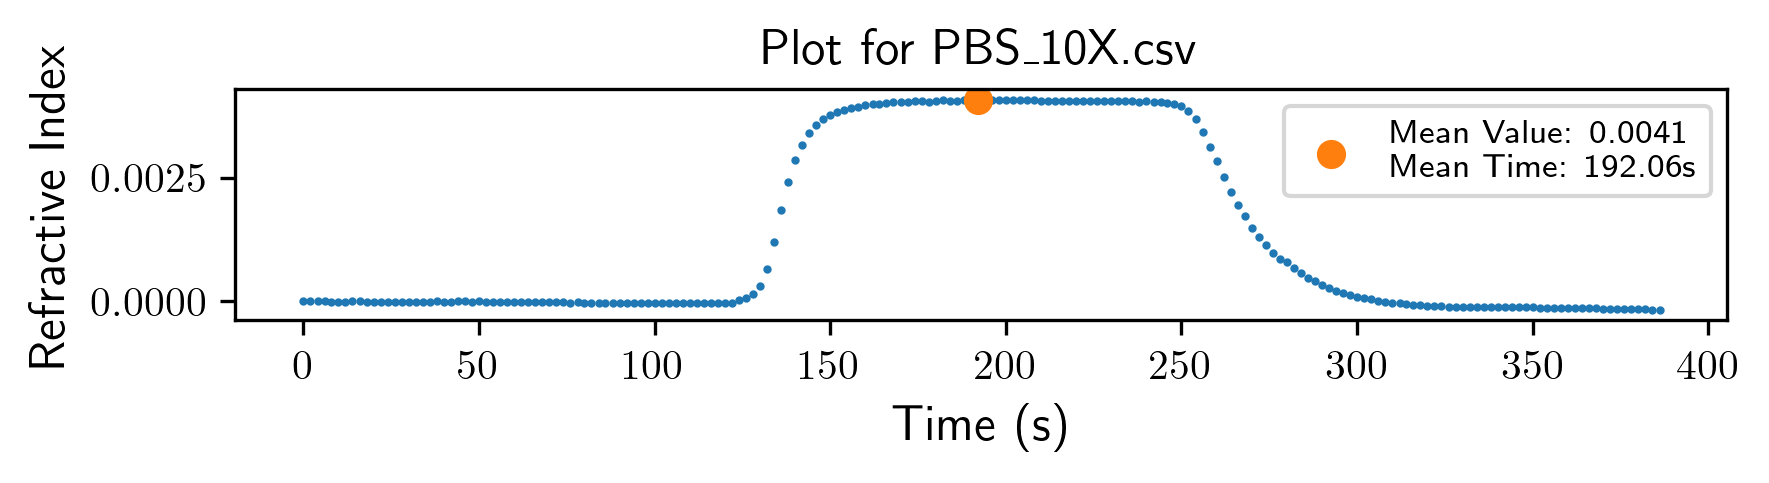

In [16]:
max_values_dict = {}
concentration = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]
window_size = 1  # Set this to the number of top values you want to average

for i, (file_name, data) in enumerate(data_dict.items()):
    # Getting the time and the refractive index
    time = data['Time']
    refrac_var = data[' Refractive Index']
    comments = data[' Comment']  # Adjust the column name as needed

    # Sort the refractive index and get the indices of the top 'window_size' values
    top_indices = refrac_var.nlargest(window_size).index
    
    # Get the mean of the top 'window_size' refractive index values and corresponding times
    mean_value = refrac_var.loc[top_indices].mean()
    mean_time = time.loc[top_indices].mean()

    # Store the mean values in the dictionary
    max_values_dict[file_name] = {
        'mean_value': mean_value, 
        'mean_time': mean_time,
        'concentration': concentration[i]  # Add the corresponding concentration
    }

    # Plotting the time versus refractive index
    fig, ax = plt.subplots(figsize=(6.417, 1), dpi=300)
    ax.scatter(time, refrac_var, s=1)
    ax.scatter(mean_time, mean_value, label=f'Mean Value: {mean_value:.4f}\nMean Time: {mean_time:.2f}s')
    ax.set_ylabel('Refractive Index')
    ax.set_xlabel('Time (s)')
    ax.legend(fontsize=8)

    # Annotate each point with the respective comment
    for t, r, c in zip(time, refrac_var, comments):
        if pd.notna(c):  # Only add text for non-NaN comments
            plt.text(t, r, str(c), fontsize=4, ha='right')

    # Add a title with the file name for reference
    ax.set_title(f'Plot for {file_name}')

    # Show the plot
    plt.show()


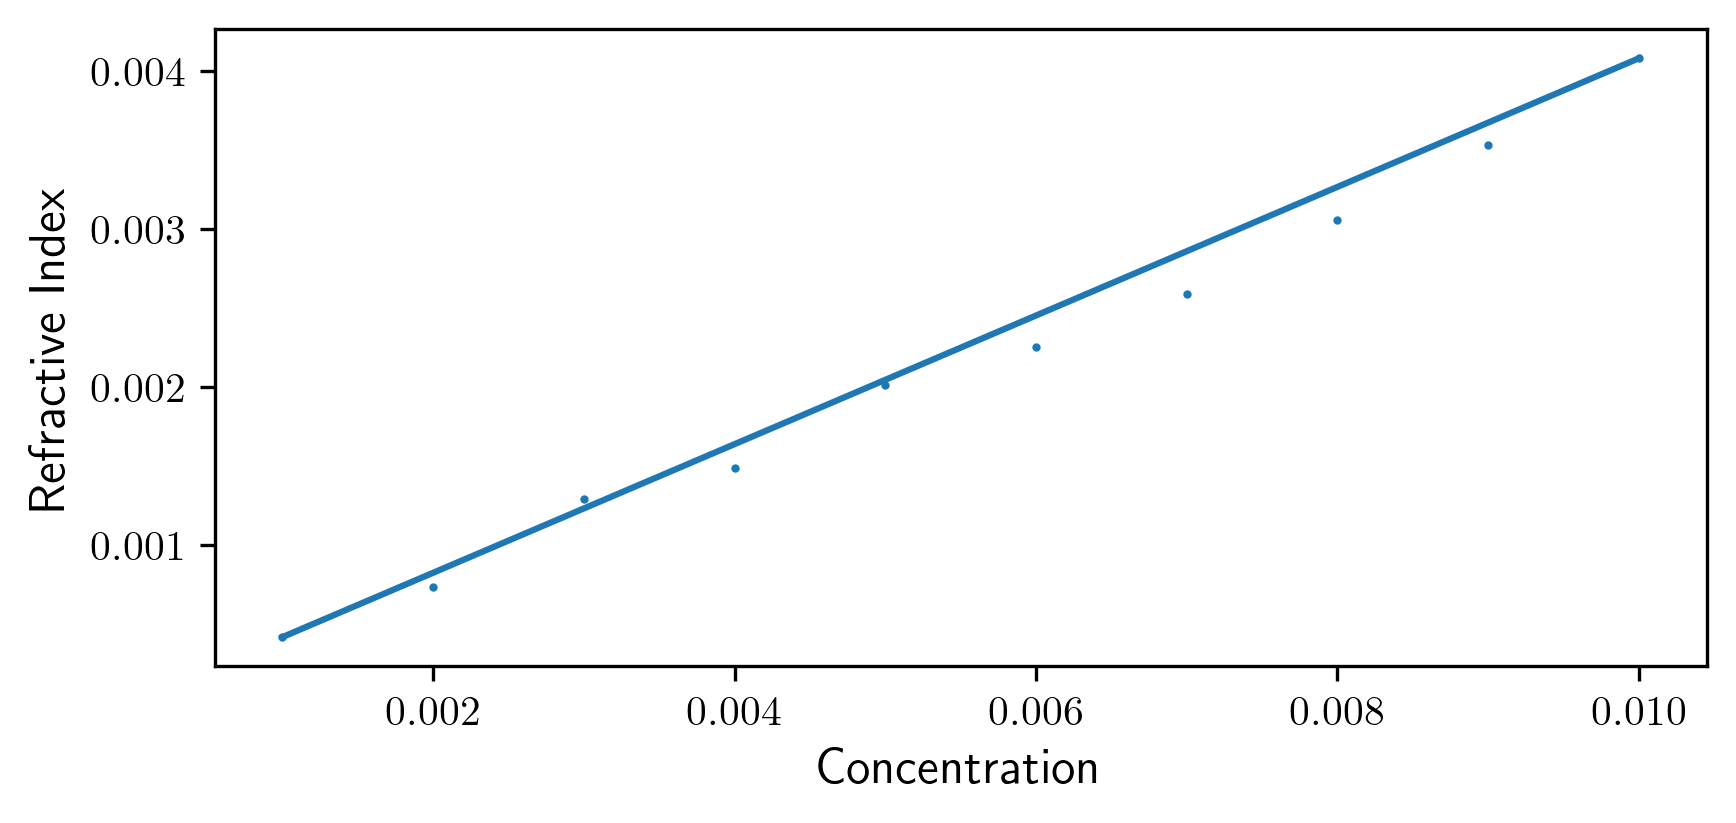

In [17]:
# Plotting the maximum value over the concentration
fig, ax = plt.subplots(figsize = (6.417,2.7559), dpi = 300)
ax.set_ylabel('Refractive Index')
ax.set_xlabel('Concentration')
max_values = []
for file_name, data in max_values_dict.items():
  max_values.append(data['mean_value'])
  ax.scatter(data['concentration'],data['mean_value'], s = 1,color = '#1f77b4')
  
C1 = max_values_dict['PBS_1X.csv']['concentration'];C2 = max_values_dict['PBS_10X.csv']['concentration']
R1 = max_values_dict['PBS_1X.csv']['mean_value'];R2 = max_values_dict['PBS_10X.csv']['mean_value']

ax.plot([C1,C2],[R1,R2])

### C. Finding $K_a$ and $\Delta \mathcal{N}_{\text{mol}}^{\text{max}}$

Using the information of two points: ($C_1$, $\Delta \mathcal{N}_{s1}^{\text{eff}}$) and ($C_2$, $\Delta \mathcal{N}_{s2}^{\text{eff}}$), a linear set of equations can be derived (In the matrix form):

$$
  \begin{bmatrix}
\Delta \mathcal{N}_{s1}^{\text{eff}} & -C_1\\
\Delta \mathcal{N}_{s2}^{\text{eff}} & -C_2
\end{bmatrix}\begin{bmatrix}
K_A^{-1}\\
\Delta \mathcal{N}_{\text{mol}}^{\text{max}}\theta_{\infty}
\end{bmatrix}=\begin{bmatrix}
-C_1\Delta \mathcal{N}_{s1}^{\text{eff}}\\
-C_2\Delta \mathcal{N}_{s2}^{\text{eff}}
\end{bmatrix}  
$$

In [18]:
C1 = max_values_dict['PBS_1X.csv']['concentration'];C2 = max_values_dict['PBS_10X.csv']['concentration']
R1 = max_values_dict['PBS_1X.csv']['mean_value'];R2 = max_values_dict['PBS_10X.csv']['mean_value']

In [19]:
A = np.array([[R1, -C1],[R2, -C2]])
B = np.array([-C1*R1, -C2*R2])
S = np.linalg.solve(A,B)
Ka = S[0]**(-1)
var_n_mol_thetainf = S[1]
Constants_1 = {
    'Ns1': [R1],
    'C1'   : [C1],
    'Ns2': [R2],
    'C2'   : [C2],
    'KA': [Ka],
    'Nmol'   : [var_n_mol_thetainf],
}

df_Constants_1 = pd.DataFrame(Constants_1)
df_Constants_1

,Ns1,C1,Ns2,C2,KA,Nmol
0,0.000418,0.001,0.004078,0.01,2.712715,0.154418


## 2.3 Cropping data

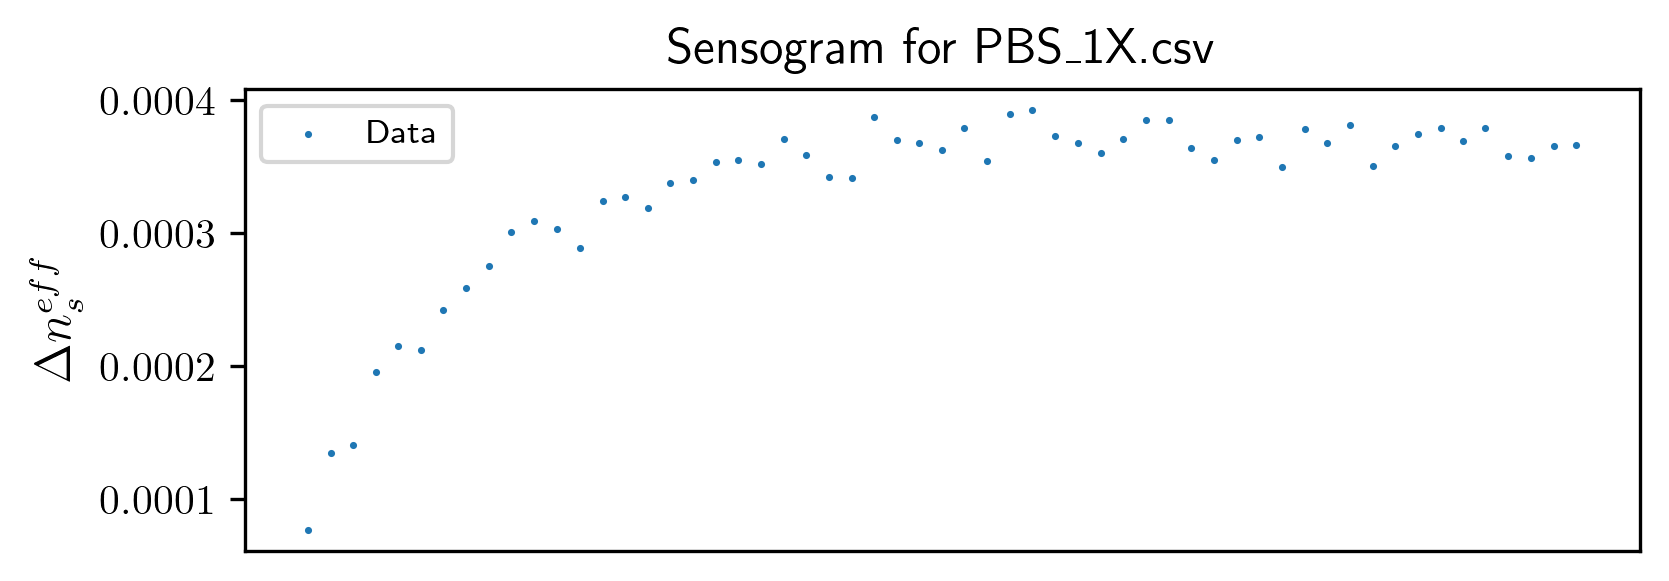

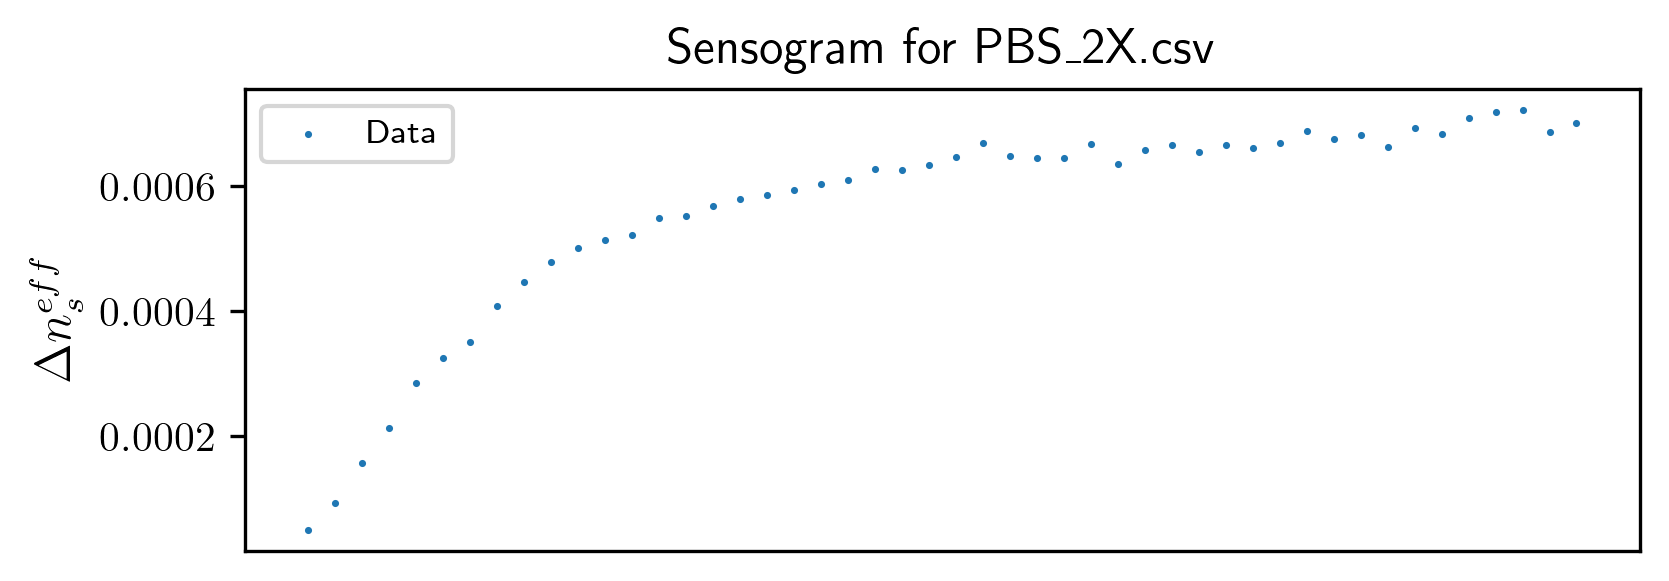

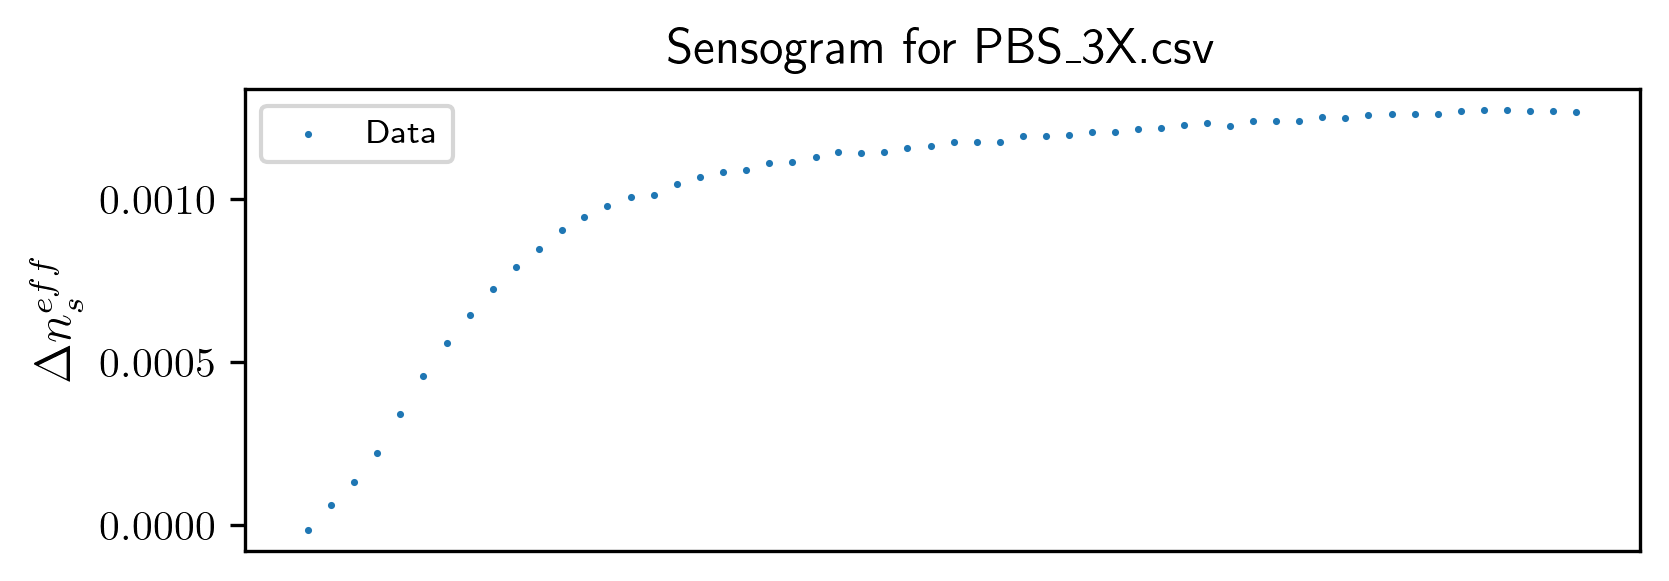

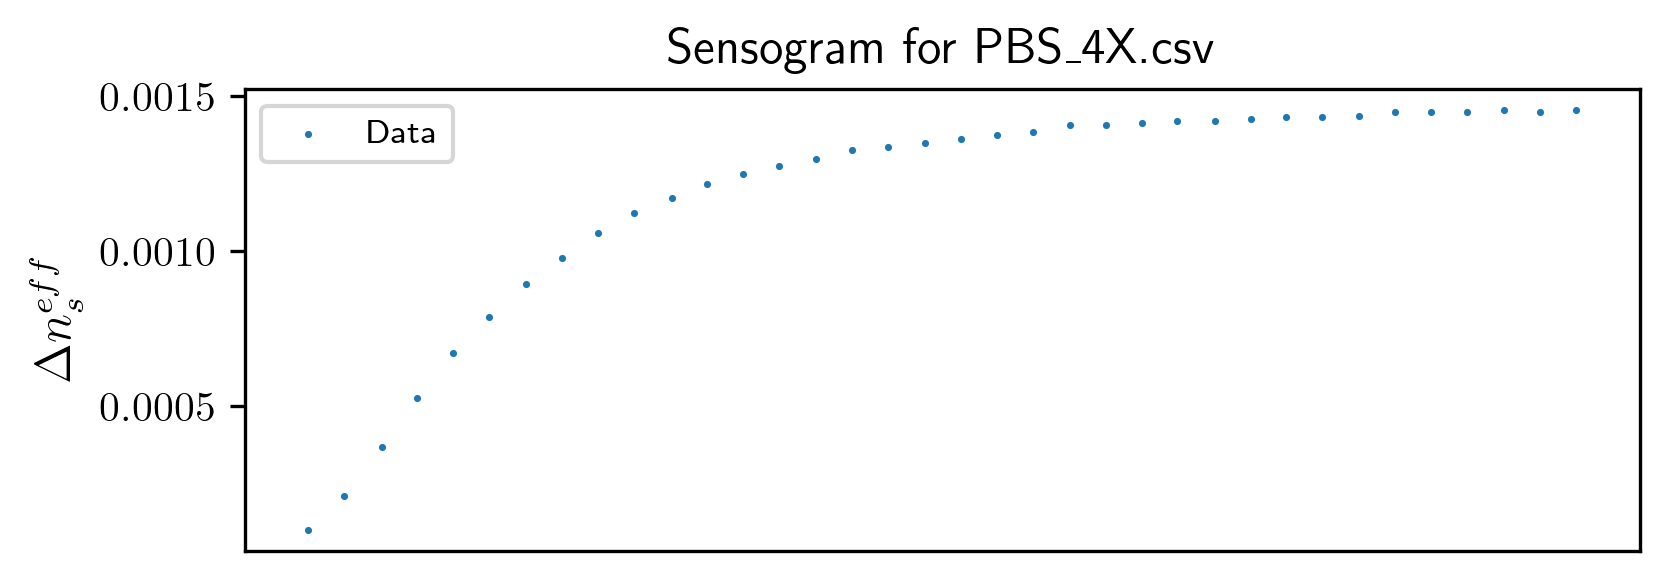

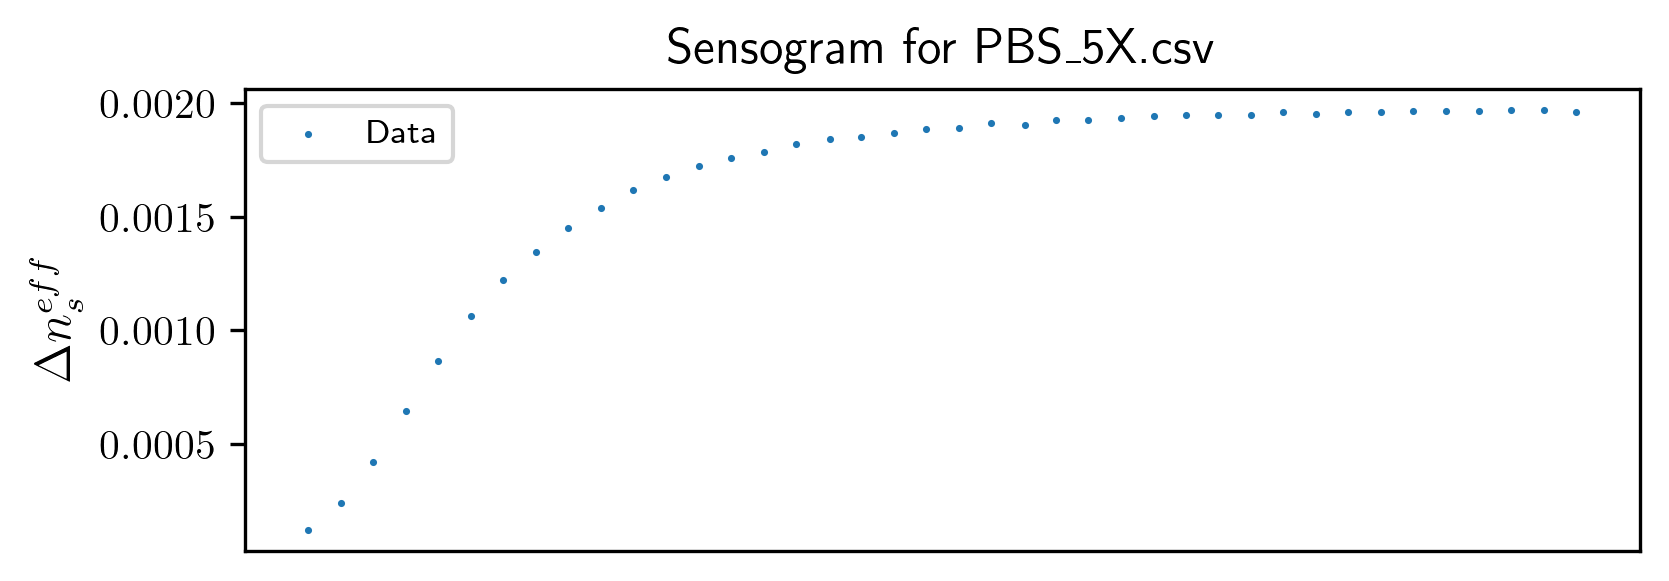

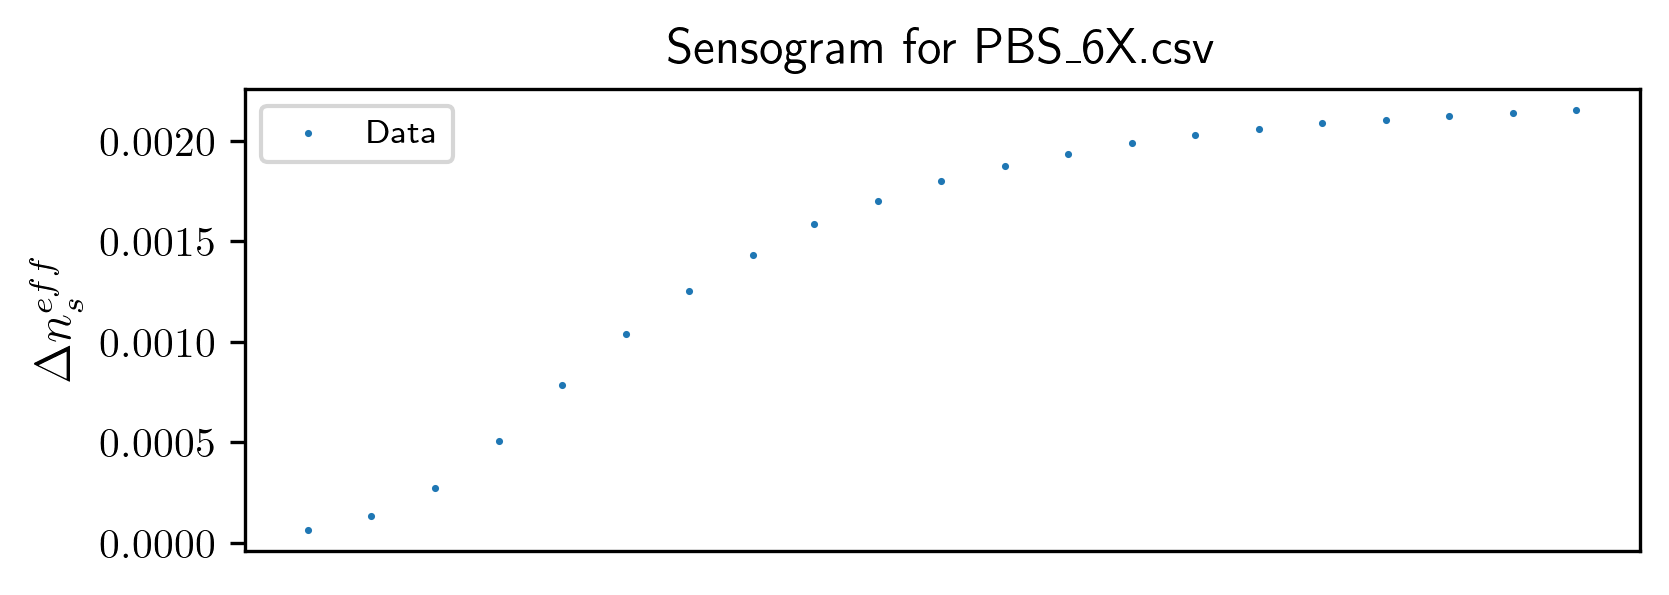

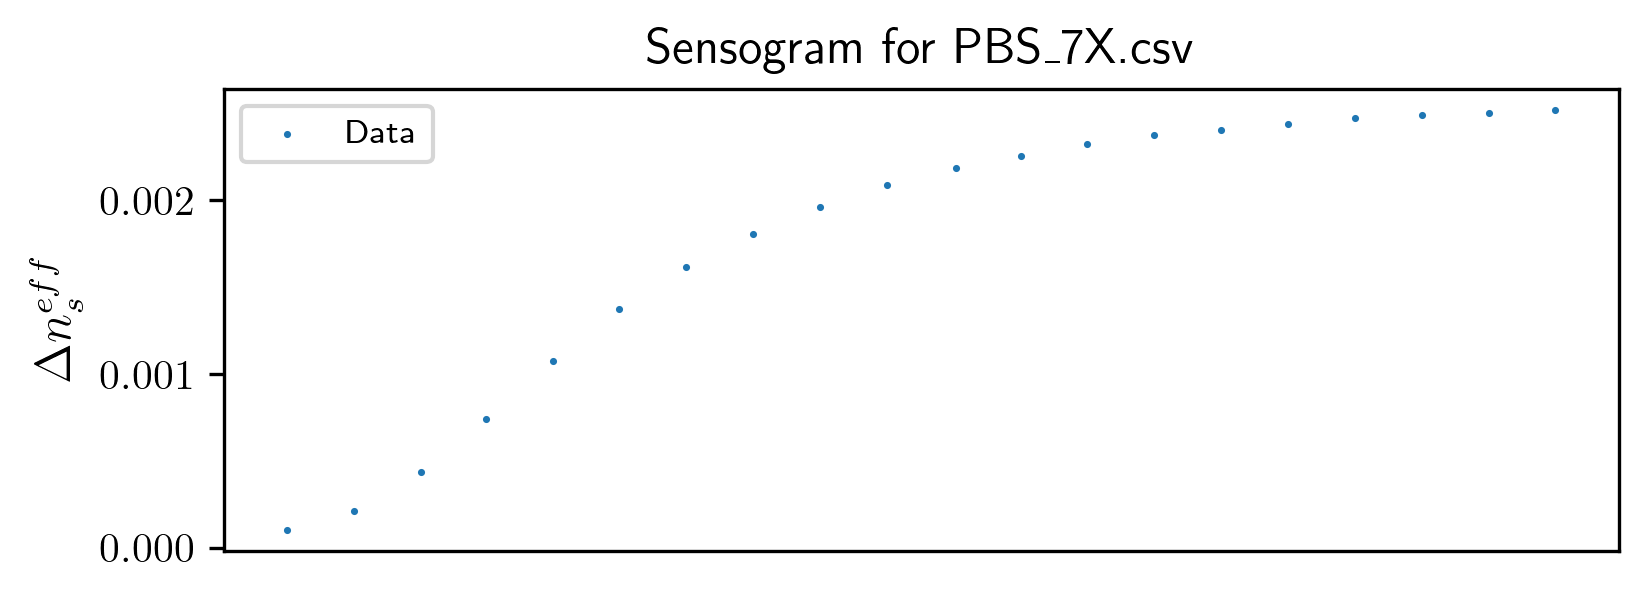

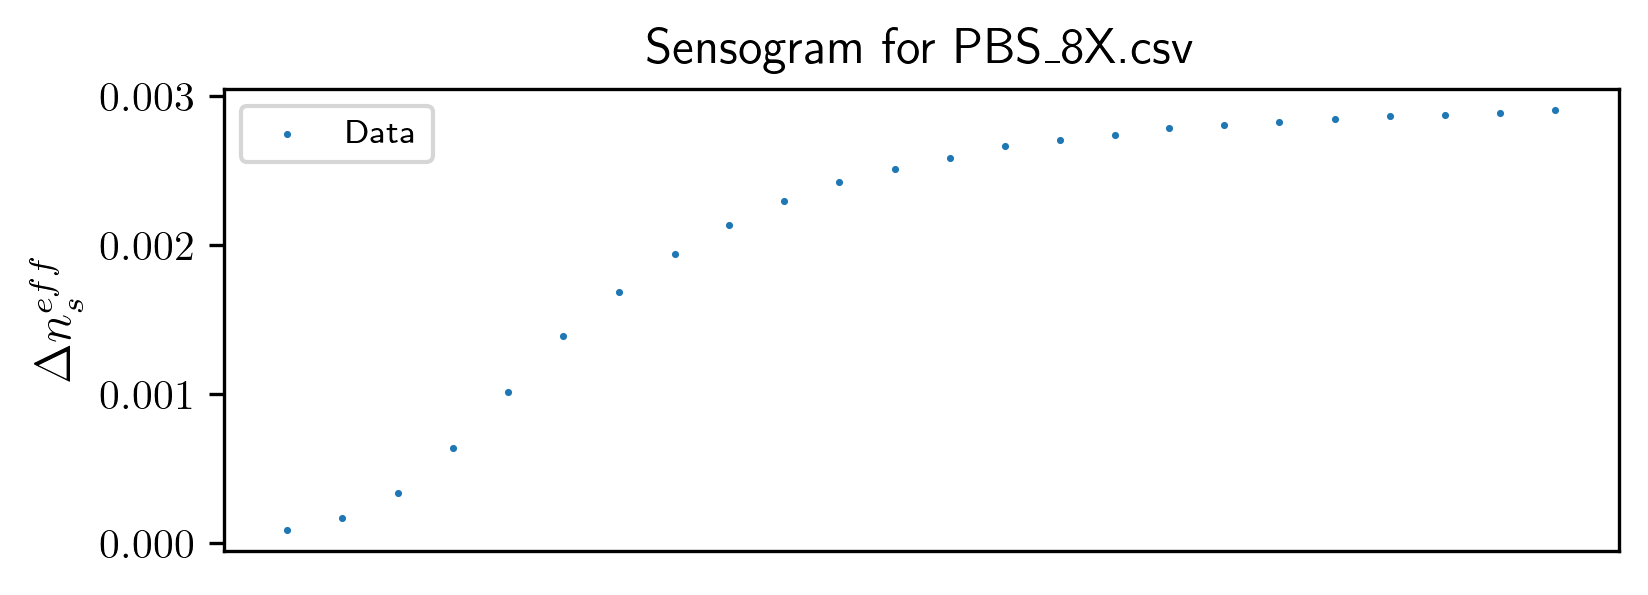

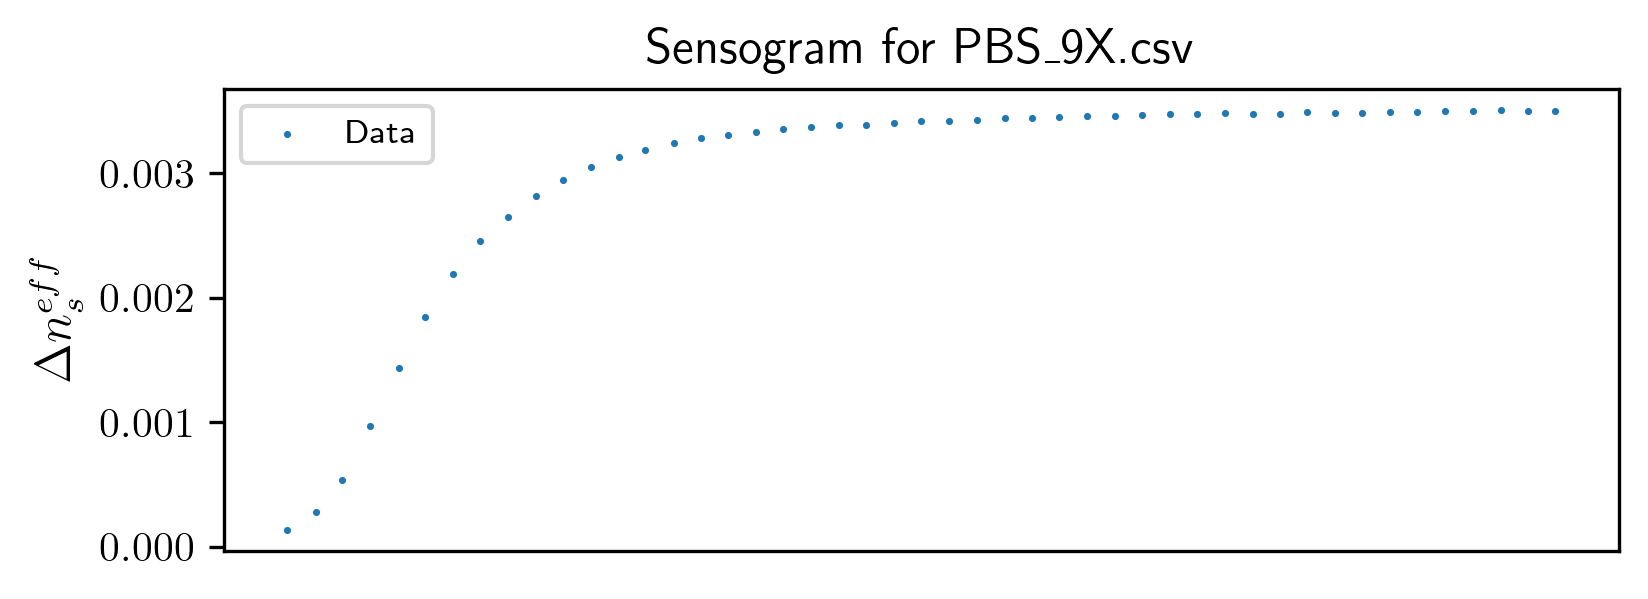

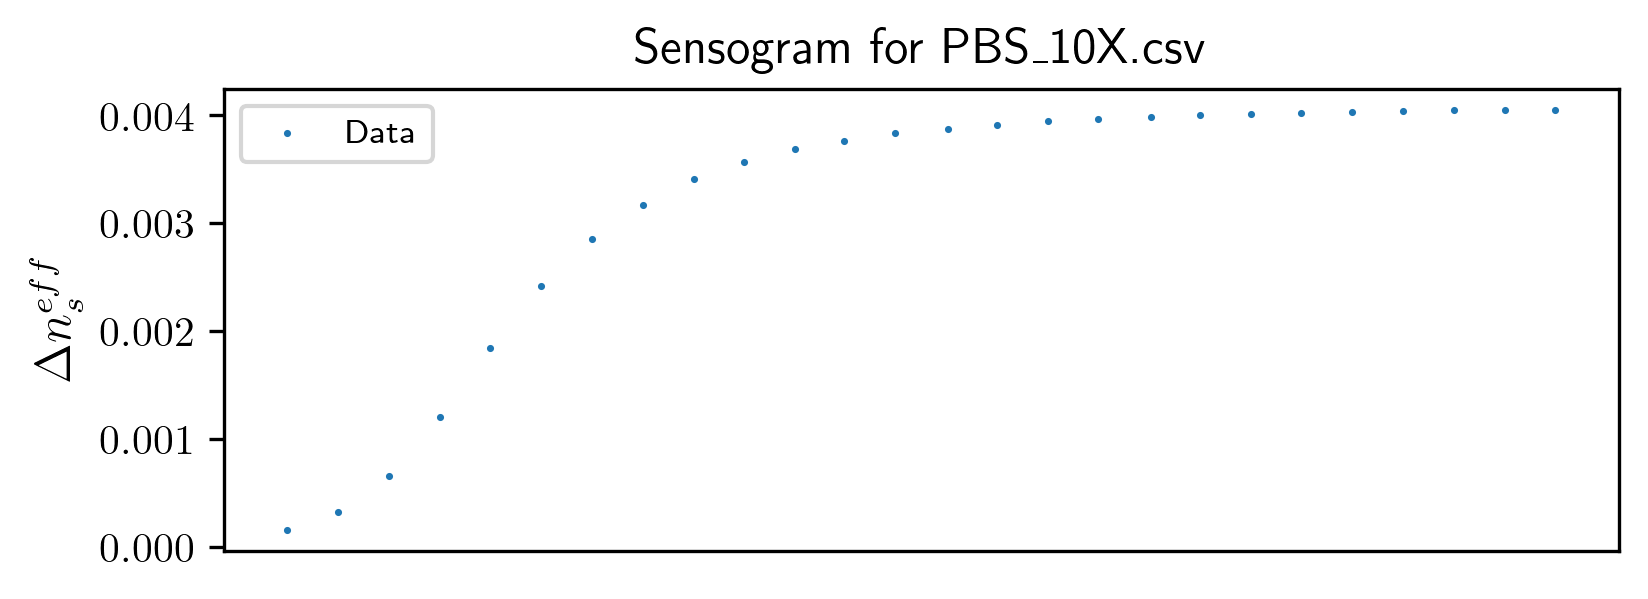

In [20]:
# RISING

# Define the starting and ending times for each concentration
i_times = [65, 85, 68, 109, 100, 139, 159, 130, 85, 127]
f_times = [180, 180, 180, 180, 180, 180, 200, 180, 180, 180]

# Dictionary to store time and refractive index data
results = {}
t_values = []
r_values = []
# Loop through each concentration
for i in range(1, 11):
    file_name = f'PBS_{i}X.csv'
    i_time = i_times[i-1]
    f_time = f_times[i-1]

    interval = np.squeeze(np.where((data_dict[file_name]['Time'] >= i_time) & (data_dict[file_name]['Time'] <= f_time)))
    t = data_dict[file_name]['Time'][interval]
    t_values.append(jnp.array(t))
    ref = data_dict[file_name][' Refractive Index'][interval]
    r_values.append(jnp.array(ref))
    
    
    #print(C_values[i-1],print(np.array(ref)[0]))
    # Store the time and refractive index data
    results[file_name] = {'Time': t, 'Refractive Index': ref}

    # Show the sensogram
    fig, ax = plt.subplots(figsize=(6, 2), dpi=300)
    ax.scatter(t, ref, s = 0.5, label = 'Data')
    ax.set_ylabel(r'$\Delta n_s^{eff}$')
    ax.set_title(f'Sensogram for {file_name}')
    ax.axes.get_xaxis().set_visible(False)
    ax.legend(fontsize = 8)

In [21]:
from scipy.interpolate import interp1d

# Função para normalizar o intervalo de amostragem para t_values e ajustar r_values
# Função para igualar o número de pontos dentro do intervalo de cada vetor
def equalize_sampling_same_length(t_values, r_values, desired_length):
    new_t_values = []
    new_r_values = []

    for t, r in zip(t_values, r_values):
        # Determinar o intervalo do vetor original
        t_min, t_max = t[0], t[-1]

        # Criar novo vetor de tempo com número fixo de pontos dentro do intervalo original
        new_t = np.linspace(t_min, t_max, desired_length)

        # Interpolação linear para o vetor de r_values associado
        interp_func_r = interp1d(t, r, kind='linear', fill_value="extrapolate")
        interpolated_r = interp_func_r(new_t)

        # Adicionar novos valores aos resultados
        new_t_values.append(new_t)
        new_r_values.append(interpolated_r)

    return new_t_values, new_r_values

# Exemplo de uso
# Usando loops for para substituir valores negativos por zero
r_values = [[max(0, x) for x in row] for row in r_values]

desired_length = 57
new_t_values, new_r_values = equalize_sampling_same_length(t_values[2:], r_values[2:], desired_length)
C_values_new = concentration[2:] 

## 2.4 RLS Method 

### A. Without Jax

Performance Metrics:
Total execution time: 0.86 seconds
Initialization time: 0.07 seconds
RLS computation time: 0.73 seconds
Average iteration time per experiment: 0.004288 seconds
Peak CPU memory usage: 1.33 MB
GPU memory usage (MB):
  - Total: 8.00
  - Used: 0.28
  - Free: 7.49
Change in GPU memory usage: 0.00 MB


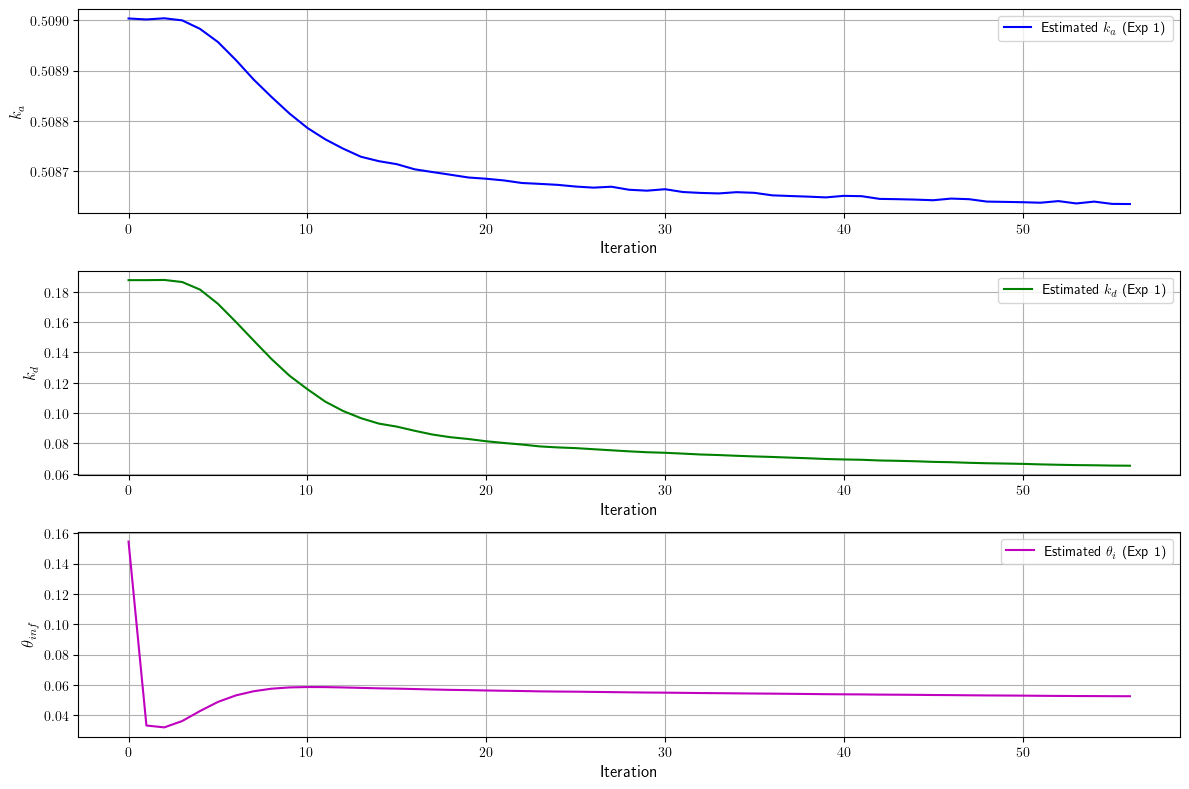

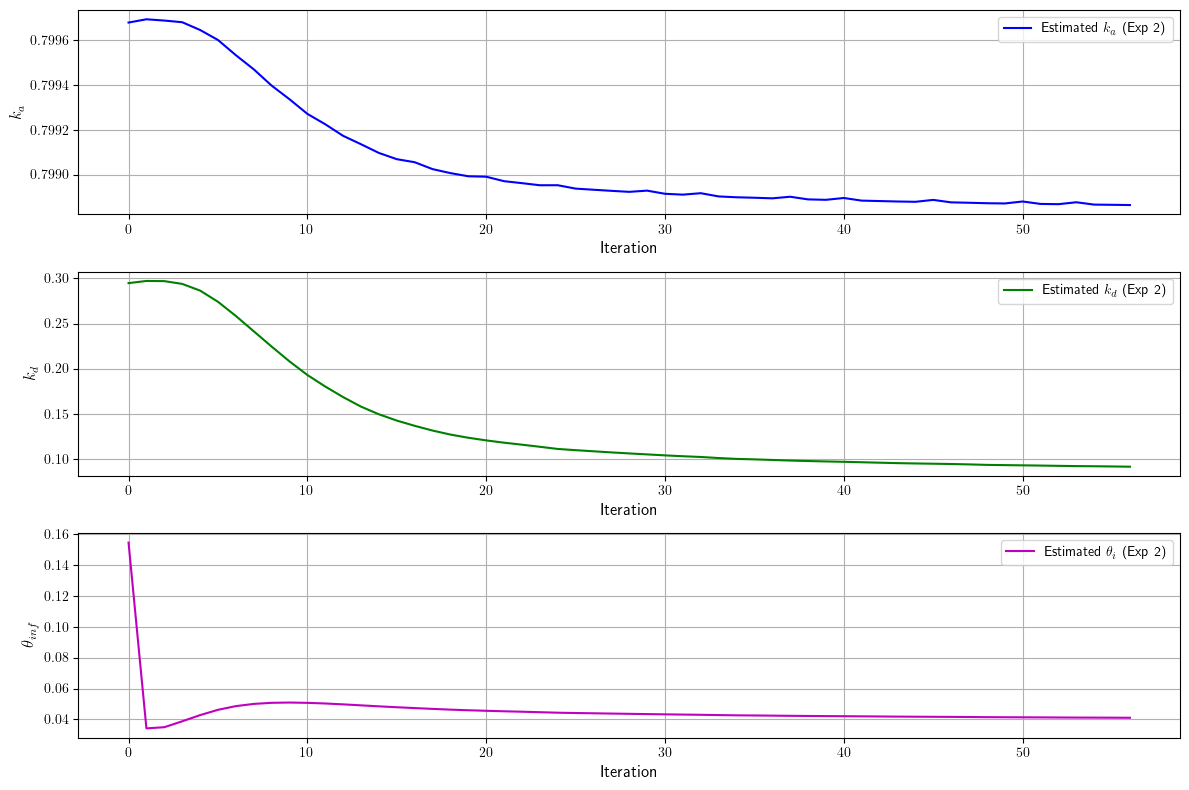

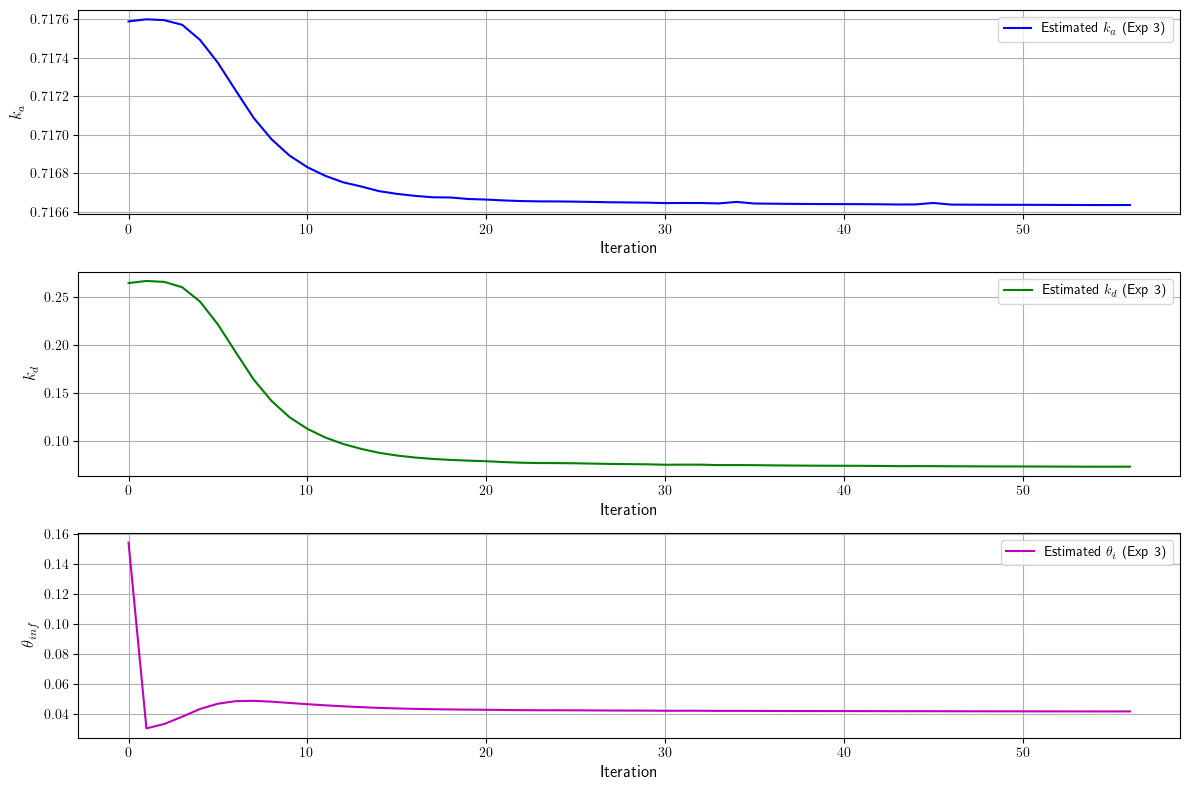

In [22]:
# Function to measure GPU memory usage using nvidia-smi
import time

def get_gpu_memory():
    try:
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=memory.total,memory.used,memory.free", "--format=csv,nounits,noheader"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
        )
        if result.returncode == 0:
            total, used, free = map(int, result.stdout.strip().split("\n")[0].split(", "))
            return {"total": total, "used": used, "free": free}
        else:
            print("Error querying GPU memory:", result.stderr)
            return {"total": 0, "used": 0, "free": 0}
    except FileNotFoundError:
        print("nvidia-smi not found. GPU memory monitoring unavailable.")
        return {"total": 0, "used": 0, "free": 0}

# Start monitoring
tracemalloc.start()
start_time = time.time()
initial_gpu_memory = get_gpu_memory()

# Define constants and initialize parameters
init_start_time = time.time()
n_experiments = len(C_values_new)  # Number of experiments

# Generate step-like inputs and time differences for each experiment
u_list, dt_list = [], []
for i in range(n_experiments):
    u = C_values_new[i] * jnp.ones(len(new_r_values[i]))
    dt = jnp.append(jnp.diff(new_t_values[i]), jnp.diff(new_t_values[i])[-1])
    u_list.append(u)
    dt_list.append(dt)
init_end_time = time.time()

# Generate outputs for each experiment
y_list = new_r_values

# Recursive Least Squares (RLS) for experiment-dependent parameters
rls_start_time = time.time()
theta_experiments = []  # To store final thetas for each experiment
theta_history_per_exp = []  # To store theta history for each experiment
P = jnp.eye(3) * 1e6  # Covariance matrix (same for all experiments)
lambda_ = 1  # Forget factor

gamma = -1
beta = -gamma * var_n_mol_thetainf
alpha = 1 - 1 / Ka

theta = jnp.array([alpha, beta, gamma])  # [alpha, beta, gamma]

for exp_idx in range(3):
    u = u_list[exp_idx]
    y = y_list[exp_idx]
    n_points = len(y)
    theta_history = []
    theta = jnp.array([alpha, beta, gamma])  # [alpha, beta, gamma]

    for k in range(n_points - 1):
        phi = jnp.array([y[k], u[k], u[k] * y[k]])
        y_obs = y[k + 1]
        K = P @ phi / (lambda_ + phi.T @ P @ phi)
        theta_history.append(theta.copy())
        theta += K * (y_obs - phi.T @ theta)
        theta = jnp.array([
            min(theta[0], 1 - 1e-6),
            max(theta[1], 1e-6),
            min(theta[2], -1e-6)
        ])
        P = (P - jnp.outer(K, phi.T @ P)) / lambda_

    theta_history.append(theta)
    theta_experiments.append(theta.copy())
    theta_history_per_exp.append(jnp.array(theta_history))
    P = jnp.eye(3) * 1e6

rls_end_time = time.time()

# Stop monitoring
end_time = time.time()
final_gpu_memory = get_gpu_memory()
cpu_memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()

# Detailed performance metrics
print("Performance Metrics:")
print(f"Total execution time: {end_time - start_time:.2f} seconds")
print(f"Initialization time: {init_end_time - init_start_time:.2f} seconds")
print(f"RLS computation time: {rls_end_time - rls_start_time:.2f} seconds")
print(f"Average iteration time per experiment: {(rls_end_time - rls_start_time)/(3*len(new_t_values[0])):.6f} seconds")
print(f"Peak CPU memory usage: {cpu_memory_usage[1] / 1024 / 1024:.2f} MB")
print(f"GPU memory usage (MB):")
print(f"  - Total: {final_gpu_memory['total'] / 1024:.2f}")
print(f"  - Used: {final_gpu_memory['used'] / 1024:.2f}")
print(f"  - Free: {final_gpu_memory['free'] / 1024:.2f}")
print(f"Change in GPU memory usage: {(final_gpu_memory['used'] - initial_gpu_memory['used']) / 1024:.2f} MB")


kd_final_list = []
ka_final_list = []
theta_inf_final_list = []
ka_history_inter = []
kd_history_inter = []
theta_history_inter = []
# Analyze results for each experiment
for exp_idx in range(3):
    theta_history = theta_history_per_exp[exp_idx]
    dt = dt_list[exp_idx]
    # Recover system parameters from theta
    alpha_history = theta_history[:, 0]
    beta_history = theta_history[:, 1]
    gamma_history = theta_history[:, 2]

    kd_history = (1 - alpha_history) / dt
    kd_history_inter.append(kd_history)
    ka_history = -gamma_history / dt
    ka_history_inter.append(ka_history)
    theta_inf_history = beta_history / (ka_history * dt)
    theta_history_inter.append(theta_inf_history)
    kd_final_list.append(kd_history[-1])
    ka_final_list.append(ka_history[-1])
    theta_inf_final_list.append(theta_inf_history[-1])


    # Plot the parameter convergence
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(ka_history, label=f"Estimated $k_a$ (Exp {exp_idx+1})", color='b')
    plt.xlabel("Iteration")
    plt.ylabel("$k_a$")
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.plot(kd_history, label=f"Estimated $k_d$ (Exp {exp_idx+1})", color='g')
    plt.xlabel("Iteration")
    plt.ylabel("$k_d$")
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 3)
    plt.plot(theta_inf_history, label=f"Estimated $\\theta_i$ (Exp {exp_idx+1})", color='m')
    plt.xlabel("Iteration")
    plt.ylabel("$\\theta_{inf}$")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

### B. With Jax

Performance Metrics:
Total execution time: 0.21 seconds
Initialization time: 0.03 seconds
RLS computation time: 0.12 seconds
Average iteration time per experiment: 0.000554 seconds
Peak CPU memory usage: 0.47 MB
GPU memory usage (MB):
  - Total: 8.00
  - Used: 0.29
  - Free: 7.48
Change in GPU memory usage: 0.01 MB


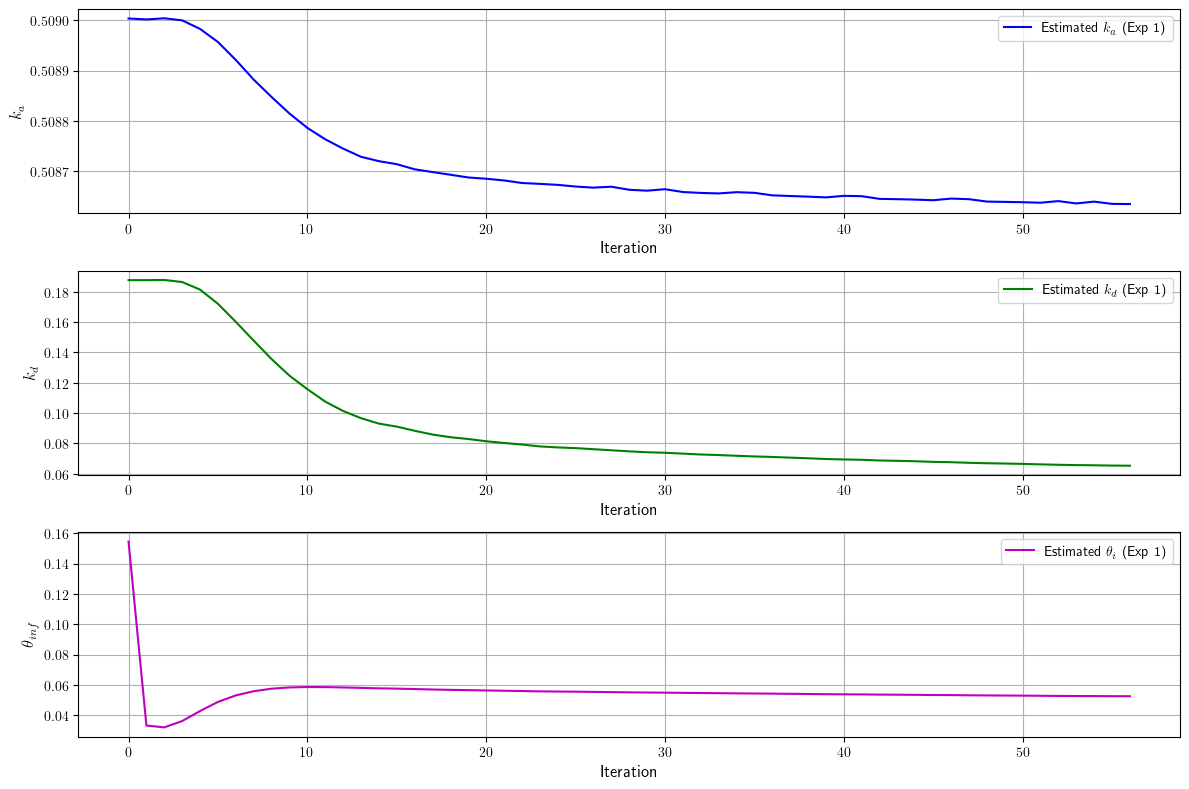

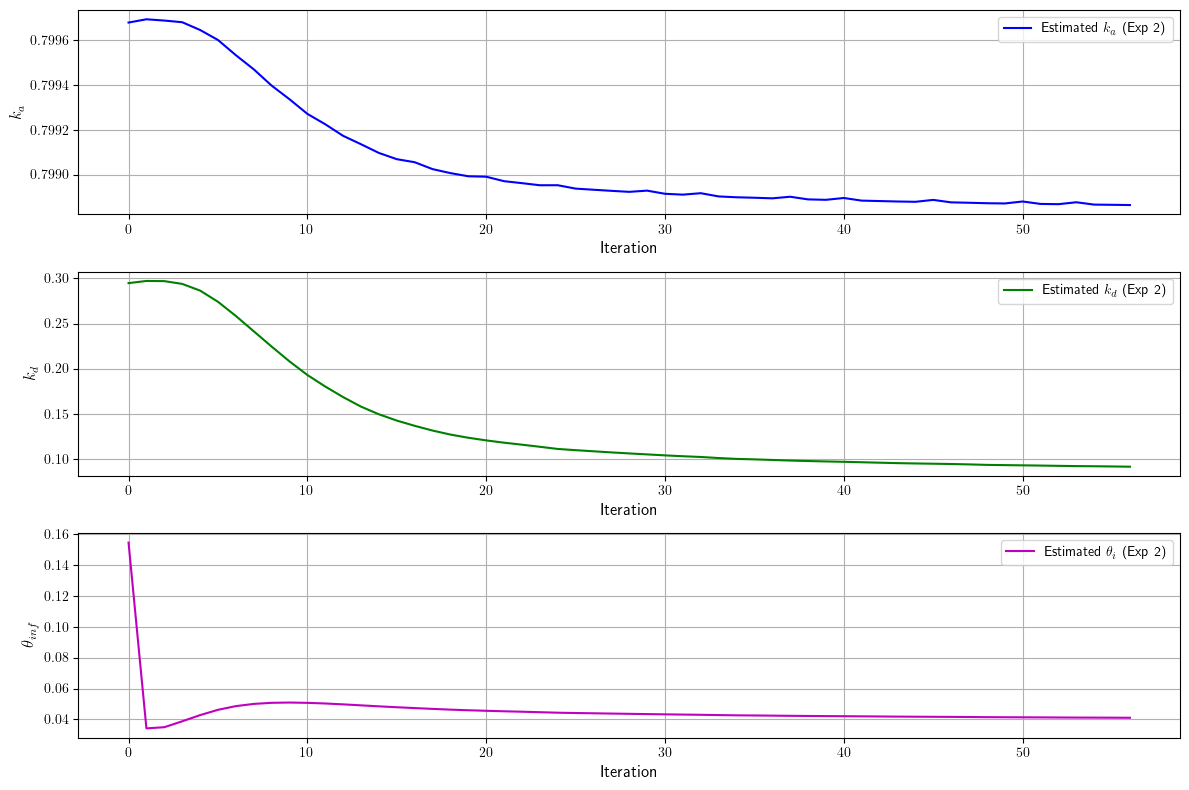

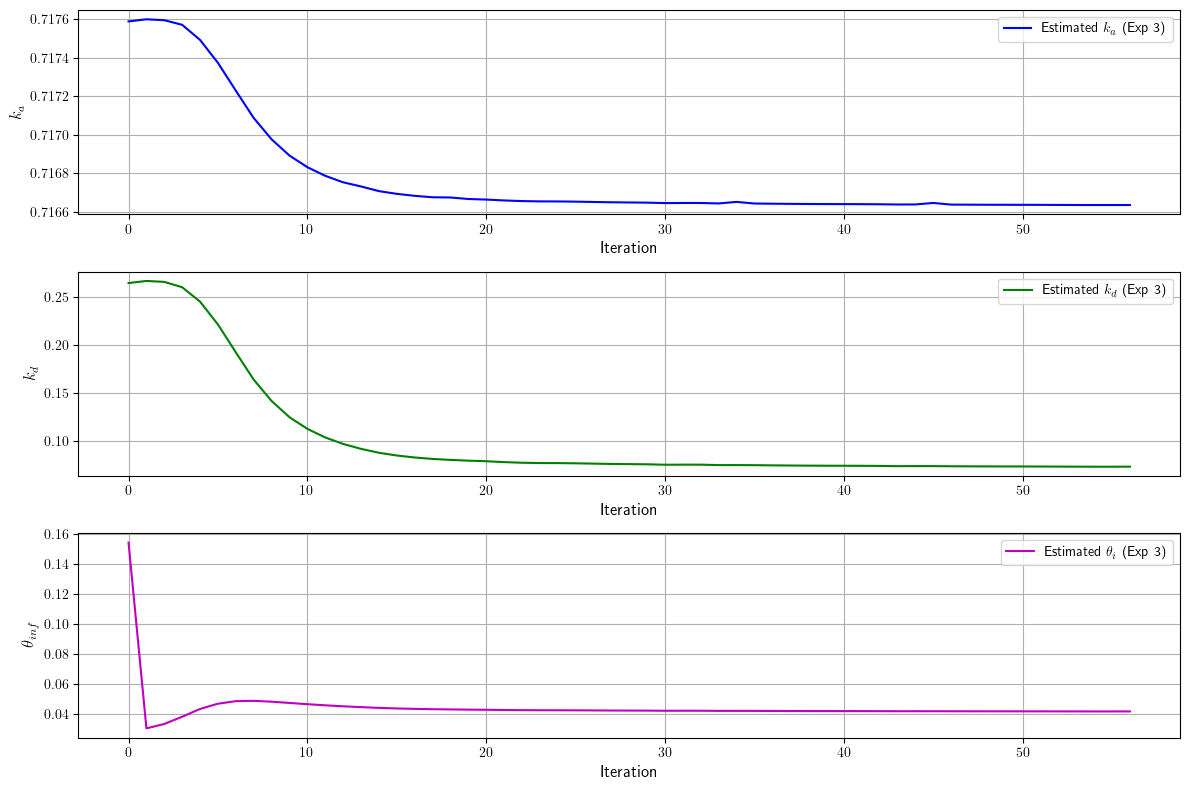

In [23]:
# Start monitoring
tracemalloc.start()
start_time = time.time()
initial_gpu_memory = get_gpu_memory()

# Define constants and initialize parameters
init_start_time = time.time()
n_experiments = len(C_values_new)  # Number of experiments

# Generate step-like inputs and time differences for each experiment
u_array = jnp.stack([C_values_new[i] * jnp.ones(len(new_r_values[i])) for i in range(n_experiments)])
dt_array = jnp.stack([jnp.append(jnp.diff(new_t_values[i]), jnp.diff(new_t_values[i])[-1]) for i in range(n_experiments)])
y_array = jnp.stack(new_r_values)
init_end_time = time.time()

# Recursive Least Squares (RLS) for experiment-dependent parameters
rls_start_time = time.time()
P_init = jnp.eye(3) * 1e6  # Covariance matrix (same for all experiments)
lambda_ = 1  # Forget factor

gamma = -1
beta = -gamma * var_n_mol_thetainf
alpha = 1 - 1 / Ka

initial_theta = jnp.array([alpha, beta, gamma])  # [alpha, beta, gamma]

def rls_step(theta, P, y_k, y_obs, u_k):
    phi = jnp.array([y_k, u_k, u_k * y_k])
    K = P @ phi / (lambda_ + phi.T @ P @ phi)
    theta = theta + K * (y_obs - phi.T @ theta)
    theta = jnp.array([
        jnp.minimum(theta[0], 1 - 1e-6),
        jnp.maximum(theta[1], 1e-6),
        jnp.minimum(theta[2], -1e-6),
    ])
    P = (P - jnp.outer(K, phi.T @ P)) / lambda_
    return theta, P

# Vectorized RLS computation

@jax.jit
def rls_experiment(u, y, dt):
    n_points = len(y)
    y_k = y[:-1]
    y_obs = y[1:]
    u_k = u[:-1]

    def step_fn(carry, inputs):
        theta, P = carry
        y_k, y_obs, u_k = inputs
        theta, P = rls_step(theta, P, y_k, y_obs, u_k)
        return (theta, P), theta

    inputs = (y_k, y_obs, u_k)
    (final_theta, _), theta_history = jax.lax.scan(step_fn, (initial_theta, P_init), inputs)
    return final_theta, theta_history

iteration_times = []
iteration_counts = []
theta_experiments = []  # Final theta values for each experiment
theta_history_per_exp = []  # Theta history for each experiment

for exp_idx in range(3):
    exp_start_time = time.time()
    final_theta, theta_history = rls_experiment(u_array[exp_idx], y_array[exp_idx], dt_array[exp_idx])
    exp_end_time = time.time()
    iteration_time = exp_end_time - exp_start_time
    iteration_count = len(y_array[exp_idx]) - 1
    iteration_times.append(iteration_time / iteration_count)
    iteration_counts.append(iteration_count)
    theta_experiments.append(final_theta)
    theta_history_per_exp.append(jnp.vstack([initial_theta, theta_history]))

average_iteration_time = sum(iteration_times) / len(iteration_times)
rls_end_time = time.time()

# Stop monitoring
end_time = time.time()
final_gpu_memory = get_gpu_memory()
cpu_memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()

# Detailed performance metrics
print("Performance Metrics:")
print(f"Total execution time: {end_time - start_time:.2f} seconds")
print(f"Initialization time: {init_end_time - init_start_time:.2f} seconds")
print(f"RLS computation time: {rls_end_time - rls_start_time:.2f} seconds")
print(f"Average iteration time per experiment: {average_iteration_time:.6f} seconds")
print(f"Peak CPU memory usage: {cpu_memory_usage[1] / 1024 / 1024:.2f} MB")
print(f"GPU memory usage (MB):")
print(f"  - Total: {final_gpu_memory['total'] / 1024:.2f}")
print(f"  - Used: {final_gpu_memory['used'] / 1024:.2f}")
print(f"  - Free: {final_gpu_memory['free'] / 1024:.2f}")
print(f"Change in GPU memory usage: {(final_gpu_memory['used'] - initial_gpu_memory['used']) / 1024:.2f} MB")

# Analyze results for each experiment
kd_final_list, ka_final_list, theta_inf_final_list = [], [], []
kd_history_inter, ka_history_inter, theta_history_inter = [], [], []

for exp_idx in range(3):
    theta_history = theta_history_per_exp[exp_idx]
    dt = dt_array[exp_idx]

    # Recover system parameters from theta
    alpha_history = theta_history[:, 0]
    beta_history = theta_history[:, 1]
    gamma_history = theta_history[:, 2]

    kd_history = (1 - alpha_history) / dt
    kd_history_inter.append(kd_history)
    ka_history = -gamma_history / dt
    ka_history_inter.append(ka_history)
    theta_inf_history = beta_history / (ka_history * dt)
    theta_history_inter.append(theta_inf_history)

    kd_final_list.append(kd_history[-1])
    ka_final_list.append(ka_history[-1])
    theta_inf_final_list.append(theta_inf_history[-1])

    # Plot the parameter convergence
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(ka_history, label=f"Estimated $k_a$ (Exp {exp_idx+1})", color='b')
    plt.xlabel("Iteration")
    plt.ylabel("$k_a$")
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.plot(kd_history, label=f"Estimated $k_d$ (Exp {exp_idx+1})", color='g')
    plt.xlabel("Iteration")
    plt.ylabel("$k_d$")
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 3)
    plt.plot(theta_inf_history, label=f"Estimated $\\theta_i$ (Exp {exp_idx+1})", color='m')
    plt.xlabel("Iteration")
    plt.ylabel("$\\theta_{inf}$")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


### C. Plots

ka 0.5367005 kd 0.06889976 thetainf 0.04982166 KA 7.789585 Nmax 1.0551789 LS 1.3392012404846876e-07
ka 0.8361838 kd 0.095580585 thetainf 0.039272748 KA 8.748469 Nmax 1.046716 LS 1.4325806528580606e-07
ka 0.7217569 kd 0.07426892 thetainf 0.041726414 KA 9.718155 Nmax 1.0071464 LS 1.0100093103360313e-07


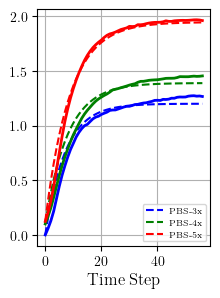

In [24]:
# Estimate the state (y_hat) for all experiments
y_hat_list = []
for exp_idx in range(3):
    final_ka = ka_final_list[exp_idx]
    final_kd = kd_final_list[exp_idx]
    final_theta_inf = theta_inf_final_list[exp_idx]
    dt = dt_list[exp_idx]
    dt = np.append(dt,dt[-1])
    y = y_list[exp_idx]
    K_a = final_ka/final_kd
    u = u_list[exp_idx]
    n_points = len(y_list[exp_idx])
    y_hat = np.zeros(n_points)  # Initialize estimated state
    y_hat[0] = y_list[exp_idx][0]  # Match initial condition
    
    for k in range(1, n_points):
        y_hat[k] = y_hat[k - 1] + dt[k] * (final_ka * u[k - 1] * (final_theta_inf - y_hat[k - 1]) - final_kd * y_hat[k - 1])
    
    y_hat_list.append(y_hat)
    N_max = (y_hat[-1] * (u[-1] + 1 / K_a)) / (u[-1] * final_theta_inf)

# Define a list of colors for each experiment
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'cyan']  # Extend if needed
plt.rc('font', family='Times New Roman', size=12)  # Use the default serif font
# Create the plot
# Set global font styles for consistency
plt.rc("axes", titlesize=12, labelsize=12)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.rc("legend", fontsize=9) # Slightly larger for readability in individual plots

# Create the figure with the correct aspect ratio
# Each plot is 6cm wide (18cm / 3) and we'll choose 8cm for the height.
# 1 inch = 2.54 cm
width_cm = 6
height_cm = 8
plt.figure(figsize=(width_cm / 2.54, height_cm / 2.54))
kd_history = []
for exp_idx in [0,1,2]:
    color = colors[exp_idx % len(colors)]  # Cycle colors if needed
    n_points = len(y_list[exp_idx])
    final_ka = ka_final_list[exp_idx]
    final_kd = kd_final_list[exp_idx]
    final_theta_inf = theta_inf_final_list[exp_idx]
    dt = dt_list[exp_idx]
    dt = np.append(dt, dt[-1])
    y = y_list[exp_idx]
    K_a = final_ka / final_kd
    u = u_list[exp_idx]
    y_hat = y_hat_list[exp_idx]
    N_max = (np.array(y)[-1] * (u[-1] + 1 / K_a)) / (u[-1] * final_theta_inf)
    MSE_value = (1/2)*np.sum((y_hat-y)**2)
    print('ka',final_ka*N_max,'kd',final_kd*N_max,'thetainf',final_theta_inf/N_max,'KA', final_ka/final_kd, 'Nmax', N_max, 'LS', MSE_value)
    kd_history.append(kd_history_inter[exp_idx]*N_max)

    
    # Format constants for the legend
    # legend_label = (f"PBS-{exp_idx + 3}x:"
    #                 f" $k_a$={final_ka * N_max:.2e}, "
    #                 f" $k_d$={final_kd * N_max:.2e},"
    #                 f" LS = {MSE_value:.2e}")
    legend_label = (f"PBS-{exp_idx + 3}x")
    # Plot actual state
    plt.plot(
        range(n_points), y_list[exp_idx]*1e3,
        color=color, linewidth=2
    )

    # Plot estimated state
    plt.plot(
        range(n_points), y_hat_list[exp_idx]*1e3,
        label=legend_label, 
        color=color, linestyle='--', linewidth=1.5
    )

# Configure axis labels, legend, and grid
plt.xlabel("Time Step")
#plt.ylabel(r'$\Delta n_s^{eff} [mRIU]$')
plt.legend(loc='best',fontsize = 6)
plt.grid(True)


# Display the plot
plt.tight_layout()
plt.savefig("estimated_state_PBS.png", dpi=300, bbox_inches='tight')
plt.show()

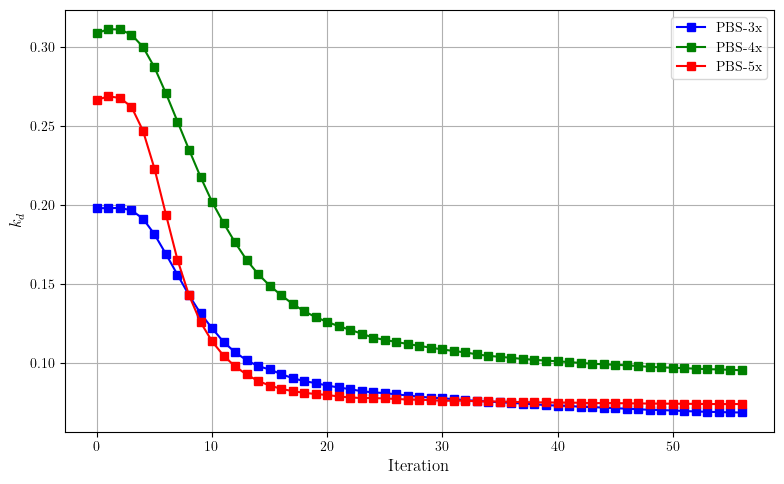

In [25]:
# Plot kd_history in the second subplot (second column)
plt.figure(figsize=(8, 5))  # Square figure size
for exp_idx in range(3):  # [0, 1, 2]
    plt.plot(kd_history[exp_idx], label=f"PBS-{exp_idx + 3}x", linestyle='-', marker='s', color=colors[exp_idx],linewidth=1.5)
plt.xlabel("Iteration")
plt.ylabel("$k_d$")
plt.legend(loc='best',fontsize = 10)
plt.grid()

# Display the plot
plt.gca().set_aspect('auto', adjustable='box')
plt.tight_layout()
plt.savefig("EstimatedConstantskd.png", dpi=300)
plt.show()

In [ ]:
import matplotlib.animation as animation

Animation successfully saved as evolving_fit_animation.mp4


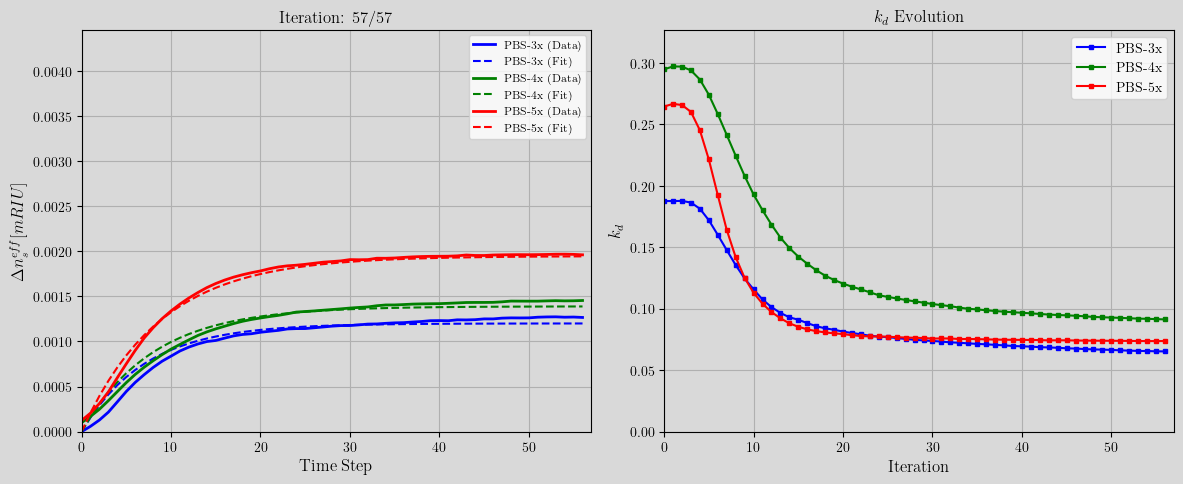

In [36]:
num_points = len(y_list[0])  # Assuming all y_list have the same length
num_iterations = len(ka_history_inter[0])  # Assuming all ka_history_inter have the same length
time = np.arange(num_points)
# --- 2. Animation Setup ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.rc('font', family='Times New Roman', size=12)
background_color = '#D9D9D9' # RGB(217, 217, 217)
fig.patch.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
lines_sensor_data = []
lines_fit_curve = []
lines_kd_history = []

ka_history_list = ka_history_inter[:3]
kd_history_list = kd_history_inter[:3]
theta_inf_history_list = theta_history_inter[:3]

# --- Plot 1: Sensorgram (Left) ---
ax1.set_xlabel("Time Step")
ax1.set_ylabel(r'$\Delta n_s^{eff} [mRIU]$')
ax1.set_title("Sensorgram Adsorption and Evolving Fit")
ax1.grid(True)
for i in range(3):
    # Data plots (will appear over time)
    line_data, = ax1.plot([], [], color=colors[i], linewidth=2, label=f"PBS-{i+3}x (Data)")
    lines_sensor_data.append(line_data)
    # Fit plots (will be redrawn each frame)
    line_fit, = ax1.plot([], [], color=colors[i], linestyle='--', linewidth=1.5, label=f"PBS-{i+3}x (Fit)")
    lines_fit_curve.append(line_fit)

# --- Plot 2: k_d Evolution (Right) ---
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$k_d$")
ax2.set_title("$k_d$ Evolution")
ax2.grid(True)
for i in range(3):
    line_kd, = ax2.plot([], [], color=colors[i], linestyle='-', marker='s', markersize=3, linewidth=1.5, label=f"PBS-{i+3}x")
    lines_kd_history.append(line_kd)

# Set plot limits based on the full potential data range
ax1.set_xlim(0, num_points)
y_min = np.min([np.min(y) for y in y_list])
y_max = np.max([np.max(y) for y in y_list])
ax1.set_ylim(y_min * 1.1, y_max * 1.1)

ax2.set_xlim(0, num_iterations)
kd_max = np.max([np.max(kd) for kd in kd_history_list])
ax2.set_ylim(0, kd_max * 1.1)

ax1.legend(loc='best', fontsize=8)
ax2.legend(loc='best', fontsize=10)
fig.tight_layout()

# --- 3. Animation Function ---
def update(frame):
    """Updates the plots for each animation frame (iteration)."""
    # Calculate how many data points to show in this frame
    points_to_show = int(((frame + 1) / num_iterations) * num_points)
    
    for i in range(3):
        # A. Update Sensorgram Data Plot (points appear over time)
        # THIS IS THE KEY CHANGE:
        lines_sensor_data[i].set_data(time[:points_to_show], y_list[i][:points_to_show])
        
        # B. Recalculate and Update the Fit Curve
        current_ka = float(ka_history_list[i][frame])
        current_kd = float(kd_history_list[i][frame])
        current_theta_inf = float(theta_inf_history_list[i][frame])
        
        # Calculate the new y_hat trajectory
        y_hat = np.zeros(num_points)
        for k in range(1, num_points):
            dt = dt_list[i][k-1] 
            y_hat[k] = y_hat[k - 1] + dt * (current_ka * u_list[i][k-1] * (current_theta_inf - y_hat[k-1]) - current_kd * y_hat[k-1])
        
        lines_fit_curve[i].set_data(time, y_hat)

        # C. Update k_d Evolution Plot
        lines_kd_history[i].set_data(np.arange(frame + 1), kd_history_list[i][:frame + 1])
        
    ax1.set_title(f"Iteration: {frame + 1}/{num_iterations}")
    return tuple(lines_sensor_data) + tuple(lines_fit_curve) + tuple(lines_kd_history)

# --- 4. Create and Save Animation ---
ani = animation.FuncAnimation(
    fig=fig, 
    func=update, 
    frames=num_iterations, 
    interval=100, 
    blit=True
)

# Save as a high-resolution MP4 file
try:
    ani.save(
        "evolving_fit_animation.mp4", 
        writer='ffmpeg', 
        fps=30,
        dpi=300, 
        codec='libx264',
        extra_args=['-pix_fmt', 'yuv420p']
    )
    print("Animation successfully saved as evolving_fit_animation.mp4")
except Exception as e:
    print(f"Error saving animation. Please ensure FFmpeg is installed and in your system's PATH. Error: {e}")

plt.show()
